# A tour of tensorflow probability

In [5]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'
%matplotlib inline
tfd = tfp.distributions
tfb = tfp.bijectors

In [14]:
def print_subclasses_from_module(module, base_class, maxwidth=80):
    import functools, inspect, sys
    subclass = [name for name, obj in inspect.getmembers(module) 
                if inspect.isclass(obj) and issubclass(obj, base_class)]
    def red(acc, x):
        if not acc or len(acc[-1]) + len(x) + 2 > maxwidth:
            acc.append(x)
        else:
            acc[-1] += ", " + x
        return acc
    print("\n".join(functools.reduce(red, subclass, [])))

In [10]:
mats = tf.random.uniform(shape=[1000, 10, 10])
vecs = tf.random.uniform(shape=[1000, 10, 1])
def for_loop_solve():
    return np.array([tf.linalg.solve(mats[i, ...], vecs[i, ...]) for i in range(1000)])
def vectorized_solve():
    return tf.linalg.solve(mats, vecs)
%timeit for_loop_solve()
%timeit vectorized_solve()

804 ms ± 55.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.38 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
a = tf.constant(np.pi)
b = tf.constant(np.e)
with tf.GradientTape() as tape:
    tape.watch([a, b])
    c = .5 * (a**2 + b**2)
grads = tape.gradient(c, [a, b])
print(grads[0])
print(grads[1])

tf.Tensor(3.1415927, shape=(), dtype=float32)
tf.Tensor(2.7182817, shape=(), dtype=float32)


In [15]:
print_subclasses_from_module(tfp.distributions, tfp.distributions.Distribution)

Autoregressive, BatchBroadcast, BatchConcat, BatchReshape, Bates, Bernoulli
Beta, BetaBinomial, BetaQuotient, Binomial, Blockwise, Categorical, Cauchy, Chi
Chi2, CholeskyLKJ, ContinuousBernoulli, DeterminantalPointProcess, Deterministic
Dirichlet, DirichletMultinomial, Distribution, DoublesidedMaxwell, Empirical
ExpGamma, ExpInverseGamma, ExpRelaxedOneHotCategorical, Exponential
ExponentiallyModifiedGaussian, FiniteDiscrete, Gamma, GammaGamma
GaussianProcess, GaussianProcessRegressionModel, GeneralizedExtremeValue
GeneralizedNormal, GeneralizedPareto, Geometric, Gumbel, HalfCauchy, HalfNormal
HalfStudentT, HiddenMarkovModel, Horseshoe, Independent, InverseGamma
InverseGaussian, JohnsonSU, JointDistribution, JointDistributionCoroutine
JointDistributionCoroutineAutoBatched, JointDistributionNamed
JointDistributionNamedAutoBatched, JointDistributionSequential
JointDistributionSequentialAutoBatched, Kumaraswamy, LKJ, LambertWDistribution
LambertWNormal, Laplace, LinearGaussianStateSpaceMod

In [16]:
normal = tfd.Normal(loc=0, scale=1.)
print(normal)

tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


C:\Users\jatin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


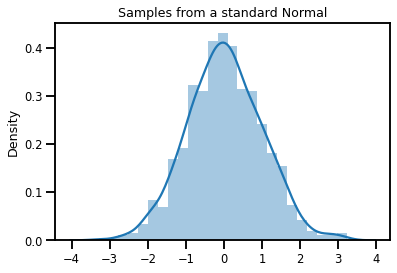

In [17]:
samples = normal.sample(1000)
sns.distplot(samples)
plt.title("Samples from a standard Normal")
plt.show()

In [18]:
normal.log_prob(0.)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9189385>

In [19]:
normal.log_prob([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.4189385, -0.9189385, -1.4189385], dtype=float32)>

In [20]:
normals = tfd.Normal([-2.5, 0., 2.5], 1.)
print("Batch shape:", normals.batch_shape)
print("Event shape:", normals.event_shape)

Batch shape: (3,)
Event shape: ()


In [21]:
samples = normals.sample(1000)
print("Shape of samples:", samples.shape)

Shape of samples: (1000, 3)


In [22]:
print("Shape of samples:", normals.sample([10, 10, 10]).shape)

Shape of samples: (10, 10, 10, 3)


In [23]:
print(normals.log_prob([-2.5, 0., 2.5]))

tf.Tensor([-0.9189385 -0.9189385 -0.9189385], shape=(3,), dtype=float32)


In [25]:
print(normals.log_prob(0.))

tf.Tensor([-4.0439386 -0.9189385 -4.0439386], shape=(3,), dtype=float32)


In [26]:
xs = np.linspace(-6, 6, 200)
try:
    normals.log_prob(xs)
except Exception as e:
    print("TFP error:", e.message)

TFP error: Incompatible shapes: [200] vs. [3] [Op:SquaredDifference]


In [27]:
try:
    np.zeros(200) + np.zeros(3)
except Exception as e:
    print("Numpy error:", e)

Numpy error: operands could not be broadcast together with shapes (200,) (3,) 


In [28]:
a = np.zeros([200, 1]) + np.zeros(3)
print("Broadcast shape:", a.shape)

Broadcast shape: (200, 3)


In [30]:
xs = np.linspace(-6, 6, 200)[..., np.newaxis]
lps = normals.log_prob(xs)
print("Broadcast log_prob shape:", lps.shape)

Broadcast log_prob shape: (200, 3)


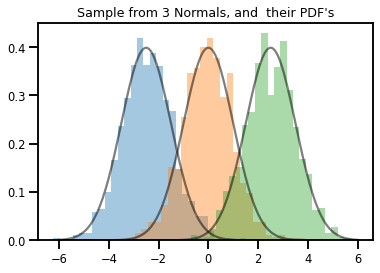

In [33]:
for i in range(3):
    sns.distplot(samples[:, i], kde=False, norm_hist=True)
plt.plot(np.tile(xs, 3), normals.prob(xs), c='k', alpha=.5)
plt.title("Sample from 3 Normals, and  their PDF's")
plt.show()

In [34]:
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.])
print("Batch shape:", mvn.batch_shape)
print("Event shape:", mvn.event_shape)

Batch shape: ()
Event shape: (2,)


In [35]:
samples = mvn.sample(1000)
print("Samples shape:", samples.shape)

Samples shape: (1000, 2)


C:\Users\jatin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


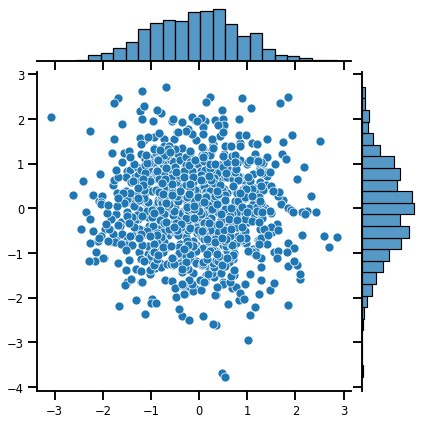

In [36]:
g = sns.jointplot(samples[:, 0], samples[:, 1], kind='scatter')
plt.show()

In [37]:
lkj = tfd.LKJ(dimension=10, concentration=[1.5, 3.0])
print("Batch shape:", lkj.batch_shape)
print("Event shape:", lkj.event_shape)

Batch shape: (2,)
Event shape: (10, 10)


In [39]:
samples = lkj.sample()
print("Samples shape:", samples.shape)

Samples shape: (2, 10, 10)


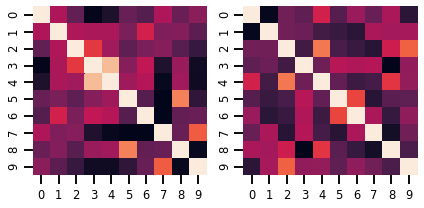

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
sns.heatmap(samples[0, ...], ax=axes[0], cbar=False)
sns.heatmap(samples[1, ...], ax=axes[1], cbar=False)
fig.tight_layout()
plt.show()

In [41]:
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()
xs = np.linspace(-5., 5., 200).reshape([-1, 1])
gp = tfd.GaussianProcess(kernel, index_points=xs)
print("Batch shape:", gp.batch_shape)
print("Event shape:", gp.event_shape)

Batch shape: ()
Event shape: (200,)


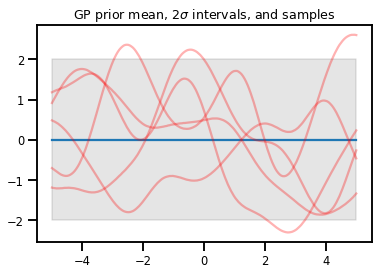

In [43]:
upper, lower = gp.mean() + [2 * gp.stddev(), -2 * gp.stddev()]
plt.plot(xs, gp.mean())
plt.fill_between(xs[..., 0], upper, lower, color='k', alpha=.1)
for _ in range(5):
    plt.plot(xs, gp.sample(), c="r", alpha=.3)
plt.title(r"GP prior mean, $2\sigma$ intervals, and samples")
plt.show()

In [44]:
obs_x = [[-.3], [0.], [2.]]
obs_y = [3., -2., 2.]
gprm = tfd.GaussianProcessRegressionModel(kernel, xs, obs_x, obs_y)

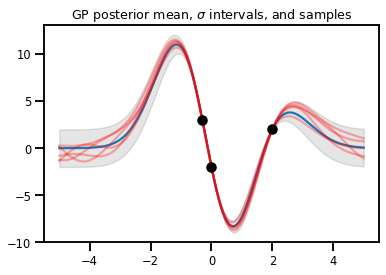

In [45]:
upper, lower = gprm.mean() + [2 * gprm.stddev(), -2 * gprm.stddev()]
plt.plot(xs, gprm.mean())
plt.fill_between(xs[..., 0], upper, lower, color='k', alpha=.1)
for _ in range(5):
    plt.plot(xs, gprm.sample(), c='r', alpha=.3)
plt.scatter(obs_x, obs_y, c='k', zorder=3)
plt.title(r"GP posterior mean, $\sigma$ intervals, and samples")
plt.show()

In [46]:
print_subclasses_from_module(tfp.bijectors, tfp.bijectors.Bijector)

AbsoluteValue, Ascending, AutoCompositeTensorBijector, BatchNormalization
Bijector, Blockwise, Chain, CholeskyOuterProduct, CholeskyToInvCholesky
Composition, CorrelationCholesky, Cumsum, DiscreteCosineTransform, Exp, Expm1
FFJORD, FillScaleTriL, FillTriangular, FrechetCDF, GeneralizedExtremeValueCDF
GeneralizedPareto, Glow, GompertzCDF, GumbelCDF, Identity, Inline, Invert
IteratedSigmoidCentered, JointMap, KumaraswamyCDF, LambertWTail, Log, Log1p
MaskedAutoregressiveFlow, MatrixInverseTriL, MatvecLU, MoyalCDF, NormalCDF
Ordered, Pad, Permute, Power, PowerTransform, RationalQuadraticSpline
RayleighCDF, RealNVP, Reciprocal, Reshape, Restructure, Scale, ScaleMatvecDiag
ScaleMatvecLU, ScaleMatvecLinearOperator, ScaleMatvecLinearOperatorBlock
ScaleMatvecTriL, Shift, ShiftedGompertzCDF, Sigmoid, Sinh, SinhArcsinh, SoftClip
Softfloor, SoftmaxCentered, Softplus, Softsign, Split, Square, Tanh
TransformDiagonal, Transpose, WeibullCDF


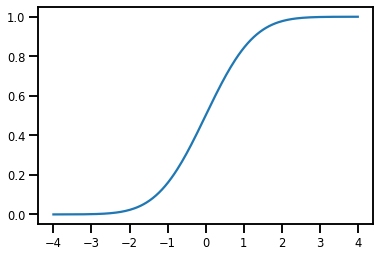

In [47]:
normal_cdf = tfp.bijectors.NormalCDF()
xs = np.linspace(-4., 4., 200)
plt.plot(xs, normal_cdf.forward(xs))
plt.show()

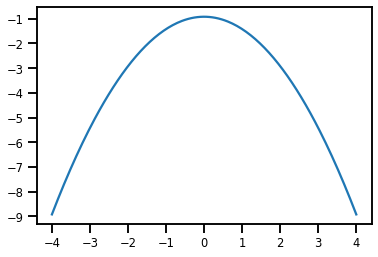

In [48]:
plt.plot(xs, normal_cdf.forward_log_det_jacobian(xs, event_ndims=0))
plt.show()

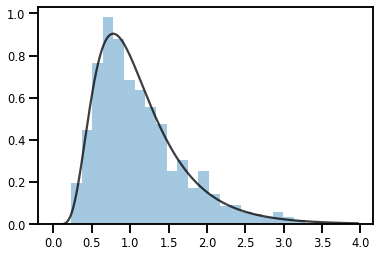

In [51]:
exp_bijector = tfp.bijectors.Exp()
log_normal = exp_bijector(tfd.Normal(0., .5))
samples = log_normal.sample(1000)
xs = np.linspace(2e-10, np.max(samples), 200)
sns.distplot(samples, norm_hist=True, kde=False)
plt.plot(xs, log_normal.prob(xs), c='k', alpha=.75)
plt.show()

In [53]:
softplus = tfp.bijectors.Softplus(hinge_softness=[1., .5, .1])
print("Hinge softness shape:", softplus.hinge_softness.shape)

Hinge softness shape: (3,)


In [54]:
xs = np.linspace(-4., 4., 200)[..., np.newaxis]
ys = softplus.forward(xs)
print("Forward shape:", ys.shape)

Forward shape: (200, 3)


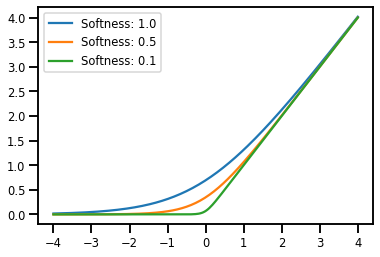

In [57]:
lines = plt.plot(np.tile(xs, 3), ys)
for line, hs in zip(lines, softplus.hinge_softness):
    line.set_label("Softness: %1.1f" %hs)
plt.legend()
plt.show()

In [58]:
bij = tfb.CholeskyOuterProduct()
size = 2500
big_lower_triangular = tf.eye(size)
big_positive_definite = bij.forward(big_lower_triangular)
%timeit bij.inverse(big_positive_definite)
%timeit tf.linalg.cholesky(big_positive_definite)

442 µs ± 39.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
772 ms ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
def f(x, w):
    x = tf.pad(x, [[1, 0], [0, 0]], constant_values=1)
    linop = tf.linalg.LinearOperatorFullMatrix(w[..., np.newaxis])
    result = linop.matmul(x, adjoint=True)
    return result
num_features = 2
num_examples = 50
noise_scale = .5
true_w = np.array([-1., 2., 3.])
xs = np.random.uniform(-1., 1., [num_features, num_examples])
ys = f(xs, true_w) + np.random.normal(0., noise_scale, size=num_examples)

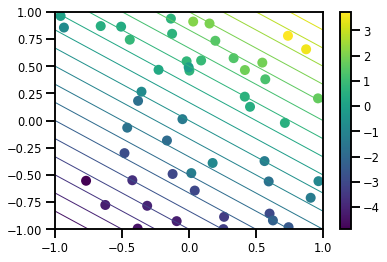

In [62]:
plt.scatter(*xs, c = ys, s=100, linewidths=0)
grid = np.meshgrid(*([np.linspace(-1, 1, 100)] * 2))
xs_grid = np.stack(grid, axis=0)
fs_grid = f(xs_grid.reshape([num_features, -1]), true_w)
fs_grid = np.reshape(fs_grid, [100, 100])
plt.colorbar()
plt.contour(xs_grid[0, ...], xs_grid[1, ...], fs_grid, 20, linewidths=1)
plt.show()

In [63]:
def joint_log_prob(w, x, y):
    rv_w = tfd.MultivariateNormalDiag(loc=np.zeros(num_features + 1), scale_diag=np.ones(num_features + 1))
    rv_y = tfd.Normal(f(x, w), noise_scale)
    return (rv_w.log_prob(w) + tf.reduce_sum(rv_y.log_prob(y), axis=-1))

In [64]:
def unnormalized_posterior(w):
    return joint_log_prob(w, xs, ys)

In [65]:
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=unnormalized_posterior, step_size=np.float64(.1), 
                                            num_leapfrog_steps=2)

In [69]:
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                                 current_state=initial_state,
                                kernel=hmc_kernel, trace_fn=lambda current_state, kernel_results: kernel_results)

In [71]:
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
    adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(hmc_kernel, num_adaptation_steps=int(.8 * num_burnin_steps),
                                                       target_accept_prob=np.float64(.65))
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                                 current_state=initial_state, kernel=adaptive_kernel, trace_fn=lambda cs, kr: kr)

# Understanding Tensorflow Distributions Shapes

In [73]:
import collections
import tensorflow as tf
tf.compat.v2.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [74]:
def describe_distributions(distributions):
    print('\n'.join([str(d) for d in distributions]))

In [75]:
poisson_distributions = [
    tfd.Poisson(rate=1., name='One Poisson Scalar Batch'),
    tfd.Poisson(rate=[1., 10., 100.], name='Three Poissons'),
    tfd.Poisson(rate=[[1., 10., 100.], [2., 20., 200.]], name="Two-by-Three Poissons"),
    tfd.Poisson(rate=[1.], name='One Poisson Vector Batch'),
    tfd.Poisson(rate=[[1.]], name='One Poisson Expanded Batch')
]
describe_distributions(poisson_distributions)

tfp.distributions.Poisson("One_Poisson_Scalar_Batch", batch_shape=[], event_shape=[], dtype=float32)
tfp.distributions.Poisson("Three_Poissons", batch_shape=[3], event_shape=[], dtype=float32)
tfp.distributions.Poisson("Two_by_Three_Poissons", batch_shape=[2, 3], event_shape=[], dtype=float32)
tfp.distributions.Poisson("One_Poisson_Vector_Batch", batch_shape=[1], event_shape=[], dtype=float32)
tfp.distributions.Poisson("One_Poisson_Expanded_Batch", batch_shape=[1, 1], event_shape=[], dtype=float32)


In [76]:
normal_distributions = [
    tfd.Normal(loc=0., scale=1., name='Standard'),
    tfd.Normal(loc=[0.], scale=1., name='Standard Vector Batch'),
    tfd.Normal(loc=[0., 1., 2., 3.], scale=1., name='Different Locs'),
    tfd.Normal(loc=[0., 1., 2., 3.], scale=[[1.], [5.]], name="Broadcasting Scale")
]
describe_distributions(normal_distributions)

tfp.distributions.Normal("Standard", batch_shape=[], event_shape=[], dtype=float32)
tfp.distributions.Normal("Standard_Vector_Batch", batch_shape=[1], event_shape=[], dtype=float32)
tfp.distributions.Normal("Different_Locs", batch_shape=[4], event_shape=[], dtype=float32)
tfp.distributions.Normal("Broadcasting_Scale", batch_shape=[2, 4], event_shape=[], dtype=float32)


In [77]:
describe_distributions([tfd.Normal(loc=[[0, 1, 2, 3], [0, 1, 2, 3]], scale=[[1, 1, 1, 1], [5, 5, 5, 5]])])

tfp.distributions.Normal("Normal", batch_shape=[2, 4], event_shape=[], dtype=float32)


In [79]:
def describe_sample_tensor_shape(sample_shape, distribution):
    print('Sample shape:', sample_shape)
    print("Returned sample tensor shape:", distribution.sample(sample_shape).shape)
def describe_sample_tensor_shapes(distributions, sample_shapes):
    started = False
    for distribution in distributions:
        print(distribution)
        for sample_shape in sample_shapes:
            describe_sample_tensor_shape(sample_shape, distribution)
        print()
sample_shapes = [1, 2, [1, 5], [3, 4, 5]]
describe_sample_tensor_shapes(poisson_distributions, sample_shapes)

tfp.distributions.Poisson("One_Poisson_Scalar_Batch", batch_shape=[], event_shape=[], dtype=float32)
Sample shape: 1
Returned sample tensor shape: (1,)
Sample shape: 2
Returned sample tensor shape: (2,)
Sample shape: [1, 5]
Returned sample tensor shape: (1, 5)
Sample shape: [3, 4, 5]
Returned sample tensor shape: (3, 4, 5)

tfp.distributions.Poisson("Three_Poissons", batch_shape=[3], event_shape=[], dtype=float32)
Sample shape: 1
Returned sample tensor shape: (1, 3)
Sample shape: 2
Returned sample tensor shape: (2, 3)
Sample shape: [1, 5]
Returned sample tensor shape: (1, 5, 3)
Sample shape: [3, 4, 5]
Returned sample tensor shape: (3, 4, 5, 3)

tfp.distributions.Poisson("Two_by_Three_Poissons", batch_shape=[2, 3], event_shape=[], dtype=float32)
Sample shape: 1
Returned sample tensor shape: (1, 2, 3)
Sample shape: 2
Returned sample tensor shape: (2, 2, 3)
Sample shape: [1, 5]
Returned sample tensor shape: (1, 5, 2, 3)
Sample shape: [3, 4, 5]
Returned sample tensor shape: (3, 4, 5, 2, 3)

In [80]:
describe_sample_tensor_shapes(normal_distributions, sample_shapes)

tfp.distributions.Normal("Standard", batch_shape=[], event_shape=[], dtype=float32)
Sample shape: 1
Returned sample tensor shape: (1,)
Sample shape: 2
Returned sample tensor shape: (2,)
Sample shape: [1, 5]
Returned sample tensor shape: (1, 5)
Sample shape: [3, 4, 5]
Returned sample tensor shape: (3, 4, 5)

tfp.distributions.Normal("Standard_Vector_Batch", batch_shape=[1], event_shape=[], dtype=float32)
Sample shape: 1
Returned sample tensor shape: (1, 1)
Sample shape: 2
Returned sample tensor shape: (2, 1)
Sample shape: [1, 5]
Returned sample tensor shape: (1, 5, 1)
Sample shape: [3, 4, 5]
Returned sample tensor shape: (3, 4, 5, 1)

tfp.distributions.Normal("Different_Locs", batch_shape=[4], event_shape=[], dtype=float32)
Sample shape: 1
Returned sample tensor shape: (1, 4)
Sample shape: 2
Returned sample tensor shape: (2, 4)
Sample shape: [1, 5]
Returned sample tensor shape: (1, 5, 4)
Sample shape: [3, 4, 5]
Returned sample tensor shape: (3, 4, 5, 4)

tfp.distributions.Normal("Broadc

In [81]:
describe_sample_tensor_shapes(normal_distributions, sample_shapes)

tfp.distributions.Normal("Standard", batch_shape=[], event_shape=[], dtype=float32)
Sample shape: 1
Returned sample tensor shape: (1,)
Sample shape: 2
Returned sample tensor shape: (2,)
Sample shape: [1, 5]
Returned sample tensor shape: (1, 5)
Sample shape: [3, 4, 5]
Returned sample tensor shape: (3, 4, 5)

tfp.distributions.Normal("Standard_Vector_Batch", batch_shape=[1], event_shape=[], dtype=float32)
Sample shape: 1
Returned sample tensor shape: (1, 1)
Sample shape: 2
Returned sample tensor shape: (2, 1)
Sample shape: [1, 5]
Returned sample tensor shape: (1, 5, 1)
Sample shape: [3, 4, 5]
Returned sample tensor shape: (3, 4, 5, 1)

tfp.distributions.Normal("Different_Locs", batch_shape=[4], event_shape=[], dtype=float32)
Sample shape: 1
Returned sample tensor shape: (1, 4)
Sample shape: 2
Returned sample tensor shape: (2, 4)
Sample shape: [1, 5]
Returned sample tensor shape: (1, 5, 4)
Sample shape: [3, 4, 5]
Returned sample tensor shape: (3, 4, 5, 4)

tfp.distributions.Normal("Broadc

In [82]:
three_poissons = tfd.Poisson(rate=[1., 10., 100.], name='Three Poissons')
three_poissons

<tfp.distributions.Poisson 'Three_Poissons' batch_shape=[3] event_shape=[] dtype=float32>

In [83]:
three_poissons.log_prob([[1., 10., 100.], [100., 10., 1]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[  -1.       ,   -2.0785608,   -3.2223587],
       [-364.73938  ,   -2.0785608,  -95.39484  ]], dtype=float32)>

In [84]:
three_poissons.log_prob([[[[1., 10., 100.], [100., 10., 1.]]]])

<tf.Tensor: shape=(1, 1, 2, 3), dtype=float32, numpy=
array([[[[  -1.       ,   -2.0785608,   -3.2223587],
         [-364.73938  ,   -2.0785608,  -95.39484  ]]]], dtype=float32)>

In [85]:
three_poissons.log_prob([10.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-16.104412 ,  -2.0785608, -69.05272  ], dtype=float32)>

In [87]:
three_poissons.log_prob([[[1.], [10.]], [[100.], [1000.]]])

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[-1.0000000e+00, -7.6974149e+00, -9.5394836e+01],
        [-1.6104412e+01, -2.0785608e+00, -6.9052719e+01]],

       [[-3.6473938e+02, -1.4348087e+02, -3.2223587e+00],
        [-5.9131279e+03, -3.6195427e+03, -1.4069575e+03]]], dtype=float32)>

In [88]:
poisson_2_by_3 = tfd.Poisson(rate=[[1., 10., 100.], [2., 20., 200.]], name='Two-by-Three Poissons')

In [89]:
poisson_2_by_3.log_prob(1.)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[  -1.       ,   -7.697415 ,  -95.39484  ],
       [  -1.3068528,  -17.004269 , -194.70169  ]], dtype=float32)>

In [90]:
poisson_2_by_3.log_prob([1.])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[  -1.       ,   -7.697415 ,  -95.39484  ],
       [  -1.3068528,  -17.004269 , -194.70169  ]], dtype=float32)>

In [91]:
poisson_2_by_3.log_prob([[1, 1, 1], [1, 1, 1]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[  -1.       ,   -7.697415 ,  -95.39484  ],
       [  -1.3068528,  -17.004269 , -194.70169  ]], dtype=float32)>

In [92]:
poisson_2_by_3.log_prob([[1, 10, 100]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ -1.       ,  -2.0785608,  -3.2223587],
       [ -1.3068528,  -5.14709  , -33.90767  ]], dtype=float32)>

In [93]:
poisson_2_by_3.log_prob([[1, 10, 100], [1, 10, 100]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ -1.       ,  -2.0785608,  -3.2223587],
       [ -1.3068528,  -5.14709  , -33.90767  ]], dtype=float32)>

In [94]:
poisson_2_by_3.log_prob([[1, 1, 1], [2, 2, 2]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[  -1.       ,   -7.697415 ,  -95.39484  ],
       [  -1.3068528,  -14.701683 , -190.09653  ]], dtype=float32)>

In [95]:
poisson_2_by_3.log_prob([[1.], [2.]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[  -1.       ,   -7.697415 ,  -95.39484  ],
       [  -1.3068528,  -14.701683 , -190.09653  ]], dtype=float32)>

In [96]:
poisson_2_by_3.log_prob([[[1, 1, 1], [1, 1, 1]], [[2, 2, 2], [2, 2, 2]]])

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[  -1.       ,   -7.697415 ,  -95.39484  ],
        [  -1.3068528,  -17.004269 , -194.70169  ]],

       [[  -1.6931472,   -6.087977 ,  -91.48282  ],
        [  -1.3068528,  -14.701683 , -190.09653  ]]], dtype=float32)>

In [97]:
poisson_2_by_3.log_prob([[[1], [1]], [[2], [2]]])

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[  -1.       ,   -7.697415 ,  -95.39484  ],
        [  -1.3068528,  -17.004269 , -194.70169  ]],

       [[  -1.6931472,   -6.087977 ,  -91.48282  ],
        [  -1.3068528,  -14.701683 , -190.09653  ]]], dtype=float32)>

In [98]:
poisson_2_by_3.log_prob([[[1, 1, 1]], [[2, 2, 2]]])

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[  -1.       ,   -7.697415 ,  -95.39484  ],
        [  -1.3068528,  -17.004269 , -194.70169  ]],

       [[  -1.6931472,   -6.087977 ,  -91.48282  ],
        [  -1.3068528,  -14.701683 , -190.09653  ]]], dtype=float32)>

In [99]:
poisson_2_by_3.log_prob([[[1]], [[2]]])

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[  -1.       ,   -7.697415 ,  -95.39484  ],
        [  -1.3068528,  -17.004269 , -194.70169  ]],

       [[  -1.6931472,   -6.087977 ,  -91.48282  ],
        [  -1.3068528,  -14.701683 , -190.09653  ]]], dtype=float32)>

In [102]:
poisson_2_by_3.log_prob(tf.constant([1., 2.])[..., tf.newaxis, tf.newaxis])

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[  -1.       ,   -7.697415 ,  -95.39484  ],
        [  -1.3068528,  -17.004269 , -194.70169  ]],

       [[  -1.6931472,   -6.087977 ,  -91.48282  ],
        [  -1.3068528,  -14.701683 , -190.09653  ]]], dtype=float32)>

In [104]:
three_poissons.log_prob([[1.], [10.], [50.], [100.]])

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[  -1.       ,   -7.697415 ,  -95.39484  ],
       [ -16.104412 ,   -2.0785608,  -69.05272  ],
       [-149.47777  ,  -43.34851  ,  -18.219261 ],
       [-364.73938  , -143.48087  ,   -3.2223587]], dtype=float32)>

In [105]:
three_poissons.log_prob(tf.constant([1., 10., 50., 100.])[..., tf.newaxis])

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[  -1.       ,   -7.697415 ,  -95.39484  ],
       [ -16.104412 ,   -2.0785608,  -69.05272  ],
       [-149.47777  ,  -43.34851  ,  -18.219261 ],
       [-364.73938  , -143.48087  ,   -3.2223587]], dtype=float32)>

In [106]:
multinomial_distributions = [
    tfd.Multinomial(total_count=100., probs=[.5, .4, .1], name="one multinomial"),
    tfd.Multinomial(total_count=[100., 1000.], probs=[.5, .4, .1], name="two multinomials same probs"),
    tfd.Multinomial(total_count=100., probs=[[.5, .4, .1], [.1, .2, .7]],
                   name="two Multnomials Same Counts"),
    tfd.Multinomial(total_count=[100., 1000.], probs=[[.5, .4, .1], [.1, .2, .7]], 
                    name="Two Multinomials Different Everything")
]
describe_distributions(multinomial_distributions)

tfp.distributions.Multinomial("one_multinomial", batch_shape=[], event_shape=[3], dtype=float32)
tfp.distributions.Multinomial("two_multinomials_same_probs", batch_shape=[2], event_shape=[3], dtype=float32)
tfp.distributions.Multinomial("two_Multnomials_Same_Counts", batch_shape=[2], event_shape=[3], dtype=float32)
tfp.distributions.Multinomial("Two_Multinomials_Different_Everything", batch_shape=[2], event_shape=[3], dtype=float32)


In [107]:
describe_sample_tensor_shapes(multinomial_distributions, sample_shapes)

tfp.distributions.Multinomial("one_multinomial", batch_shape=[], event_shape=[3], dtype=float32)
Sample shape: 1
Returned sample tensor shape: (1, 3)
Sample shape: 2
Returned sample tensor shape: (2, 3)
Sample shape: [1, 5]
Returned sample tensor shape: (1, 5, 3)
Sample shape: [3, 4, 5]
Returned sample tensor shape: (3, 4, 5, 3)

tfp.distributions.Multinomial("two_multinomials_same_probs", batch_shape=[2], event_shape=[3], dtype=float32)
Sample shape: 1
Returned sample tensor shape: (1, 2, 3)
Sample shape: 2
Returned sample tensor shape: (2, 2, 3)
Sample shape: [1, 5]
Returned sample tensor shape: (1, 5, 2, 3)
Sample shape: [3, 4, 5]
Returned sample tensor shape: (3, 4, 5, 2, 3)

tfp.distributions.Multinomial("two_Multnomials_Same_Counts", batch_shape=[2], event_shape=[3], dtype=float32)
Sample shape: 1
Returned sample tensor shape: (1, 2, 3)
Sample shape: 2
Returned sample tensor shape: (2, 2, 3)
Sample shape: [1, 5]
Returned sample tensor shape: (1, 5, 2, 3)
Sample shape: [3, 4, 5]
R

In [109]:
two_multivariate_normals = tfd.MultivariateNormalDiag(loc=[1., 2., 3.], scale_identity_multiplier=[1., 2.])
two_multivariate_normals

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[2] event_shape=[3] dtype=float32>

In [110]:
two_multivariate_normals.log_prob([[[1., 2., 3.]], [[3., 4., 5.]]])

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-2.7568154, -4.836257 ],
       [-8.756816 , -6.336257 ]], dtype=float32)>

In [111]:
two_multivariate_normals.log_prob(tf.constant([[1., 2., 3.], [3., 4., 5.]])[:, tf.newaxis, :])

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-2.7568154, -4.836257 ],
       [-8.756816 , -6.336257 ]], dtype=float32)>

In [112]:
two_multivariate_normals.log_prob(tf.constant([[1., 2., 3.], [3., 4., 5.]]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-2.7568154, -6.336257 ], dtype=float32)>

In [113]:
six_way_multinomial = tfd.Multinomial(total_count=1000., probs=[.3, .25, .2, .15, .08, .02])
six_way_multinomial

<tfp.distributions.Multinomial 'Multinomial' batch_shape=[] event_shape=[6] dtype=float32>

In [115]:
transformed_multinomial = tfd.TransformedDistribution(distribution=six_way_multinomial, 
                                                      bijector=tfb.Reshape(event_shape_out=[2, 3]))
transformed_multinomial

<tfp.distributions.TransformedDistribution 'reshapeMultinomial' batch_shape=[] event_shape=[2, 3] dtype=float32>

In [116]:
six_way_multinomial.log_prob([500., 100., 100., 150., 100., 50.])

<tf.Tensor: shape=(), dtype=float32, numpy=-178.22021>

In [117]:
transformed_multinomial.log_prob([[500., 100., 100.], [150., 100., 50.]])

<tf.Tensor: shape=(), dtype=float32, numpy=-178.22021>

In [118]:
two_by_five_bernoulli = tfd.Bernoulli(probs=[[.05, .1, .15, .2, .25], [.3, .35, .4, .45, .5]], 
                                      name="Two By Five Bernoulli")
two_by_five_bernoulli

<tfp.distributions.Bernoulli 'Two_By_Five_Bernoulli' batch_shape=[2, 5] event_shape=[] dtype=int32>

In [119]:
pattern = [[1., 0., 0., 1., 0.], [0., 0., 1., 1., 1.]]
two_by_five_bernoulli.log_prob(pattern)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[-2.9957323 , -0.10536052, -0.16251893, -1.609438  , -0.28768206],
       [-0.35667497, -0.4307829 , -0.9162907 , -0.79850775, -0.6931472 ]],
      dtype=float32)>

In [120]:
two_sets_of_five = tfd.Independent(distribution=two_by_five_bernoulli, reinterpreted_batch_ndims=1, 
                                   name="Two Sets of Five")
two_sets_of_five

<tfp.distributions.Independent 'Two_Sets_of_Five' batch_shape=[2] event_shape=[5] dtype=int32>

In [121]:
two_sets_of_five.log_prob(pattern)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-5.160732 , -3.1954036], dtype=float32)>

In [122]:
one_set_of_two_by_five = tfd.Independent(distribution=two_by_five_bernoulli, reinterpreted_batch_ndims=2, 
                                        name="One Set Of Two By Five")
one_set_of_two_by_five.log_prob(pattern)

<tf.Tensor: shape=(), dtype=float32, numpy=-8.356134>

In [124]:
describe_sample_tensor_shapes([
    two_by_five_bernoulli,
    two_sets_of_five,
    one_set_of_two_by_five
], [[3, 5]])

tfp.distributions.Bernoulli("Two_By_Five_Bernoulli", batch_shape=[2, 5], event_shape=[], dtype=int32)
Sample shape: [3, 5]
Returned sample tensor shape: (3, 5, 2, 5)

tfp.distributions.Independent("Two_Sets_of_Five", batch_shape=[2], event_shape=[5], dtype=int32)
Sample shape: [3, 5]
Returned sample tensor shape: (3, 5, 2, 5)

tfp.distributions.Independent("One_Set_Of_Two_By_Five", batch_shape=[], event_shape=[2, 5], dtype=int32)
Sample shape: [3, 5]
Returned sample tensor shape: (3, 5, 2, 5)



# Tensorflow Distributions: A Gentle Introduction

In [1]:
import collections
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
try:
    tf.compat.v1.enable_eager_execution()
except ValueError:
    pass
import matplotlib.pyplot as plt

In [2]:
n = tfd.Normal(loc=0., scale=1.)
n

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [3]:
n.sample()

<tf.Tensor: shape=(), dtype=float32, numpy=-0.116767794>

In [4]:
n.sample(3)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.5392527 , -0.11497502,  0.58079916], dtype=float32)>

In [5]:
n.log_prob(0.)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9189385>

In [6]:
n.log_prob([0., 2., 4.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.9189385, -2.9189386, -8.918939 ], dtype=float32)>

In [7]:
b = tfd.Bernoulli(probs=0.7)
b

<tfp.distributions.Bernoulli 'Bernoulli' batch_shape=[] event_shape=[] dtype=int32>

In [8]:
b.sample()

<tf.Tensor: shape=(), dtype=int32, numpy=1>

In [9]:
b.sample(8)

<tf.Tensor: shape=(8,), dtype=int32, numpy=array([1, 1, 1, 0, 1, 0, 1, 0])>

In [10]:
b.log_prob([1, 0, 1, 0])

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.35667497, -1.2039728 , -0.35667497, -1.2039728 ], dtype=float32)>

In [12]:
nd = tfd.MultivariateNormalDiag(loc=[0., 10.], scale_diag=[1., 4.])
nd

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [13]:
tfd.Normal(loc=0., scale=1.)

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [14]:
nd.sample()

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-2.1460078, 12.049484 ], dtype=float32)>

In [15]:
nd.sample(5)

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[-0.28560397,  8.448871  ],
       [-0.34272733, 17.595955  ],
       [ 0.08943494, 10.788352  ],
       [-1.3049259 ,  6.446069  ],
       [-0.5695178 ,  6.329594  ]], dtype=float32)>

In [16]:
nd.log_prob([0., 10.])

<tf.Tensor: shape=(), dtype=float32, numpy=-3.2241714>

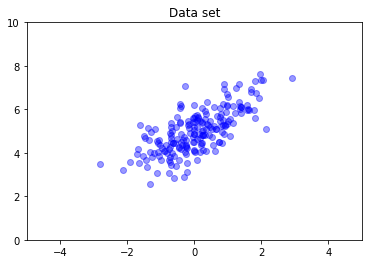

In [18]:
nd = tfd.MultivariateNormalFullCovariance(loc=[0., 5.], covariance_matrix=[[1., .7], [.7, 1.]])
data = nd.sample(200)
plt.scatter(data[:, 0], data[:, 1], color="blue", alpha=0.4)
plt.axis([-5, 5, 0, 10])
plt.title("Data set")
plt.show()

In [20]:
b3 = tfd.Bernoulli(probs=[.3, .5, .7])
b3

<tfp.distributions.Bernoulli 'Bernoulli' batch_shape=[3] event_shape=[] dtype=int32>

In [22]:
b3.sample()

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 0, 1])>

In [23]:
b3.sample(6)

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[0, 0, 1],
       [1, 1, 1],
       [0, 0, 1],
       [0, 1, 1],
       [0, 0, 0],
       [0, 1, 1]])>

In [24]:
b3.prob([1, 1, 0])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.29999998, 0.5       , 0.29999998], dtype=float32)>

In [25]:
b3_joint = tfd.Independent(b3, reinterpreted_batch_ndims=1)
b3_joint

<tfp.distributions.Independent 'IndependentBernoulli' batch_shape=[] event_shape=[3] dtype=int32>

In [26]:
b3

<tfp.distributions.Bernoulli 'Bernoulli' batch_shape=[3] event_shape=[] dtype=int32>

In [28]:
b3_joint.prob([1, 1, 0])

<tf.Tensor: shape=(), dtype=float32, numpy=0.044999998>

In [29]:
tf.reduce_prod(b3.prob([1, 1, 0]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.044999994>

In [31]:
nd_batch = tfd.MultivariateNormalFullCovariance(loc=[[0., 0.], [1., 1.], [2., 2.]], 
                                                covariance_matrix = [[[1., .1], [.1, 1.]],
                                                                    [[1., .3], [.3, 1.]],
                                                                    [[1., .5], [.5, 1.]]])
nd_batch

<tfp.distributions.MultivariateNormalFullCovariance 'MultivariateNormalFullCovariance' batch_shape=[3] event_shape=[2] dtype=float32>

In [32]:
nd_batch.sample(4)

<tf.Tensor: shape=(4, 3, 2), dtype=float32, numpy=
array([[[ 0.23631737, -0.46800578],
        [ 2.0550525 ,  1.7257216 ],
        [ 1.7917993 ,  1.6113943 ]],

       [[-1.0302098 ,  1.6383836 ],
        [ 1.1320927 ,  0.14806497],
        [ 2.6532702 ,  0.9358456 ]],

       [[-0.73611933, -1.7560107 ],
        [ 0.02230418,  3.3266134 ],
        [ 1.4018286 ,  1.9295481 ]],

       [[-0.1458562 , -0.3847303 ],
        [ 1.0246055 , -0.18547189],
        [ 2.8812325 ,  1.3054513 ]]], dtype=float32)>

In [33]:
nd_batch.log_prob([[0., 0.], [1., 1.], [2., 2.]])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.8328519, -1.7907217, -1.694036 ], dtype=float32)>

In [34]:
n = tfd.Normal(loc=0., scale=1.)
n

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [35]:
n.log_prob(0.)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9189385>

In [36]:
n.log_prob([0.])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.9189385], dtype=float32)>

In [37]:
n.log_prob([[0., 1.], [-1., 2.]])

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.9189385, -1.4189385],
       [-1.4189385, -2.9189386]], dtype=float32)>

In [38]:
nd = tfd.MultivariateNormalDiag(loc=[0., 1.], scale_diag=[1., 1.])
nd

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [39]:
nd.log_prob([0., 0.])

<tf.Tensor: shape=(), dtype=float32, numpy=-2.337877>

In [40]:
nd.log_prob([[0., 0.], [1., 1.], [2., 2.]])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-2.337877 , -2.337877 , -4.3378773], dtype=float32)>

In [41]:
nd.log_prob([0.])

<tf.Tensor: shape=(), dtype=float32, numpy=-2.337877>

In [42]:
nd.log_prob([[0.], [1.], [2.]])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-2.337877 , -2.337877 , -4.3378773], dtype=float32)>

In [43]:
b3 = tfd.Bernoulli(probs=[.3, .5, .7])

In [44]:
b3.prob([1])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.29999998, 0.5       , 0.7       ], dtype=float32)>

In [45]:
b3.prob([[0], [1]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.7, 0.5, 0.3],
       [0.3, 0.5, 0.7]], dtype=float32)>

In [50]:
b3.log_prob([[0.], [1]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-0.35667497, -0.6931472 , -1.2039728 ],
       [-1.2039728 , -0.6931472 , -0.35667497]], dtype=float32)>

# Learnable Distributions Zoo

In [51]:
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.internal import prefer_static
tfb = tfp.bijectors
tfd = tfp.distributions
tf.enable_v2_behavior()

In [52]:
event_size = 4
num_components = 3

In [54]:
learnable_mvn_scaled_identity = tfd.Independent(tfd.Normal(loc=tf.Variable(tf.zeros(event_size), name='loc'),
                                                          scale=tfp.util.TransformedVariable(tf.ones([1]), 
                                                                                             bijector=tfb.Exp(), 
                                                                                             name='scale')), 
                                               reinterpreted_batch_ndims=1, name="learnable_mvn_scaled_identity")
print(learnable_mvn_scaled_identity)
print(learnable_mvn_scaled_identity.trainable_variables)

tfp.distributions.Independent("learnable_mvn_scaled_identity", batch_shape=[], event_shape=[4], dtype=float32)
(<tf.Variable 'loc:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'scale:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>)


In [56]:
learnable_mvndiag = tfd.Independent(tfd.Normal(loc=tf.Variable(tf.zeros(event_size), name='loc'), 
                                              scale=tfp.util.TransformedVariable(tf.ones(event_size), 
                                                                                bijector=tfb.Softplus(), name='scale')),
                                   reinterpreted_batch_ndims=1, name="kearnable_mvn_diag")
print(learnable_mvndiag)
print(learnable_mvndiag.trainable_variables)

tfp.distributions.Independent("kearnable_mvn_diag", batch_shape=[], event_shape=[4], dtype=float32)
(<tf.Variable 'loc:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'scale:0' shape=(4,) dtype=float32, numpy=array([0.54132485, 0.54132485, 0.54132485, 0.54132485], dtype=float32)>)


In [58]:
learnable_mix_mvn_scaled_identity = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=tf.Variable(
                                    -tf.math.log(1.) * tf.range(num_components, dtype=tf.float32), name='logits')),
                                                         components_distribution=tfd.Independent(tfd.Normal(loc=
                                            tf.Variable(tf.random.normal([num_components, event_size]), name='loc'),
                                                                            scale=tfp.util.TransformedVariable(
                                                                            10. * tf.ones([num_components, 1]),
                                                                            bijector=tfb.Softplus(), name='scale')),
                                                                            reinterpreted_batch_ndims=1), 
                                                         name='learnable_mix_mvn_scaled_identity')
print(learnable_mix_mvn_scaled_identity)
print(learnable_mix_mvn_scaled_identity.trainable_variables)

tfp.distributions.MixtureSameFamily("learnable_mix_mvn_scaled_identity", batch_shape=[], event_shape=[4], dtype=float32)
(<tf.Variable 'logits:0' shape=(3,) dtype=float32, numpy=array([-0., -0., -0.], dtype=float32)>, <tf.Variable 'loc:0' shape=(3, 4) dtype=float32, numpy=
array([[ 0.05710917,  0.7879651 , -0.33085525, -1.2211281 ],
       [-0.3008914 ,  1.9992889 , -0.00691364,  1.1721272 ],
       [ 1.7374858 ,  0.15409772,  0.47984084, -2.2031732 ]],
      dtype=float32)>, <tf.Variable 'scale:0' shape=(3, 1) dtype=float32, numpy=
array([[9.999954],
       [9.999954],
       [9.999954]], dtype=float32)>)


In [60]:
learnable_mix_mvndiag_first_fixed = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=
                                                        tfp.util.TransformedVariable(-tf.math.log(1.5) * tf.range
                                                        (num_components, dtype=tf.float32), tfb.Pad(paddings=[[1, 0]],
                                                        constant_values=0)), name="logits"), components_distribution=
                                                         tfd.Independent(tfd.Normal(loc=tf.Variable(
                                                             tfp.random.rademacher([num_components, event_size]), 
                                                             name='loc'), scale=tfp.util.TransformedVariable(10.* tf.ones(
                                                         [num_components, 1]), bijector=tfb.Softplus(), name='scale')), 
                                                                         reinterpreted_batch_ndims=1), 
                                                          name='learnable_mix_mvndiag_first_fixed')
print(learnable_mix_mvndiag_first_fixed)
print(learnable_mix_mvndiag_first_fixed.trainable_variables)

tfp.distributions.MixtureSameFamily("learnable_mix_mvndiag_first_fixed", batch_shape=[], event_shape=[4], dtype=float32)
(<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([-0.4054651, -0.8109302], dtype=float32)>, <tf.Variable 'loc:0' shape=(3, 4) dtype=float32, numpy=
array([[ 1.,  1.,  1., -1.],
       [-1.,  1.,  1.,  1.],
       [-1., -1., -1.,  1.]], dtype=float32)>, <tf.Variable 'scale:0' shape=(3, 1) dtype=float32, numpy=
array([[9.999954],
       [9.999954],
       [9.999954]], dtype=float32)>)


In [61]:
learnable_mix_mvntril = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=
                                            tf.Variable(-tf.math.log(1.) * tf.range(num_components, dtype=tf.float32),
                                                       name='logits')), components_distribution=
                                              tfd.MultivariateNormalTriL(loc=tf.Variable(tf.zeros([num_components, 
                                                                                                   event_size]), 
                                                name='loc'), scale_tril=tfp.util.TransformedVariable(10. * tf.eye(
                                              event_size, batch_shape=[num_components]), bijector=tfb.FillScaleTriL(),
                                                                                name="scale_tril")), 
                                              name='learrnable_mix_mvntril')
print(learnable_mix_mvntril)
print(learnable_mix_mvntril.trainable_variables)

tfp.distributions.MixtureSameFamily("learrnable_mix_mvntril", batch_shape=[], event_shape=[4], dtype=float32)
(<tf.Variable 'loc:0' shape=(3, 4) dtype=float32, numpy=
array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>, <tf.Variable 'scale_tril:0' shape=(3, 10) dtype=float32, numpy=
array([[9.999945, 0.      , 0.      , 0.      , 9.999945, 9.999945,
        0.      , 0.      , 0.      , 9.999945],
       [9.999945, 0.      , 0.      , 0.      , 9.999945, 9.999945,
        0.      , 0.      , 0.      , 9.999945],
       [9.999945, 0.      , 0.      , 0.      , 9.999945, 9.999945,
        0.      , 0.      , 0.      , 9.999945]], dtype=float32)>, <tf.Variable 'logits:0' shape=(3,) dtype=float32, numpy=array([-0., -0., -0.], dtype=float32)>)


In [63]:
num_tril_nonzero = lambda num_rows: num_rows * (num_rows + 1) // 2
num_tril_rows = lambda nnz: prefer_static.cast(prefer_static.sqrt(0.25 + 2. * prefer_static.cast(nnz, tf.float32))
                                               - 0.5, tf.int32)
class PadEye(tfb.Bijector):
    def __init__(self, tril_fn=None):
        if tril_fn is None:
            tril_fn = tfb.FillScaleTriL()
        self._tril_fn = getattr(tril_fn, 'inverse', tril_fn)
        super(PadEye, self).__init__(forward_min_event_ndims=2, inverse_min_event_ndims=2, is_constant_jacobian=True, 
                                     name='PadEye')
    def _forward(self, x):
        num_rows = int(num_tril_rows(tf.compat.dimension_value(x.shape[-1])))
        eye = tf.eye(num_rows, batch_shape=prefer_static.shape(x)[:-2])
        return tf.concat([self._tril_fn(eye)[..., tf.newaxis, :], x], axis=prefer_static.rank(x) - 2)
    
    def _inverse(self, y):
        return y[..., 1:, :]
    
    def _forward_log_det_jacobian(self, x):
        return tf.zeros([], dtype=x.dtype)
    
    def _inverse_log_det_jacobian(self, y):
        return tf.zeros([], dtype=y.dtype)
    
    def _forward_event_shape(self, in_shape):
        n = prefer_static.size(in_shape)
        return in_shape + prefer_static.one_hot(n - 2, depth=n, dtype=tf.int32)
    
    def _inverse_event_shape(self, out_shape):
        n = prefer_static.size(out_shape)
        return out_shape - prefer_static.one_hot(n - 2, depth=n, dtype=tf.int32)
    
tril_bijector = tfb.FillScaleTriL(diag_bijector=tfb.Softplus())
learnable_mix_mvntril_fixed_first = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=
                                        tfp.util.TransformedVariable(-tf.math.log(1.) * tf.range(num_components, 
                                        dtype=tf.float32), bijector=tfb.Pad(paddings=[(1, 0)]), name="logits")), 
                                        components_distribution=tfd.MultivariateNormalTriL(loc=
                                        tfp.util.TransformedVariable(tf.zeros([num_components, event_size]), 
                                                                     bijector=tfb.Pad(paddings=[(1, 0)]), 
                                        name='loc'), scale_tril=tfp.util.TransformedVariable(10. * tf.eye(event_size
                                        , batch_shape=[num_components]), bijector=tfb.Chain([tril_bijector, 
                                        PadEye(tril_bijector)]), name='scale_tril')), 
                                                              name="learnable_mix_mvntril_fixed_first")
print(learnable_mix_mvntril_fixed_first)
print(learnable_mix_mvntril_fixed_first.trainable_variables)

tfp.distributions.MixtureSameFamily("learnable_mix_mvntril_fixed_first", batch_shape=[], event_shape=[4], dtype=float32)
(<tf.Variable 'loc:0' shape=(3, 3) dtype=float32, numpy=
array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)>, <tf.Variable 'scale_tril:0' shape=(2, 10) dtype=float32, numpy=
array([[9.999945, 0.      , 0.      , 0.      , 9.999945, 9.999945,
        0.      , 0.      , 0.      , 9.999945],
       [9.999945, 0.      , 0.      , 0.      , 9.999945, 9.999945,
        0.      , 0.      , 0.      , 9.999945]], dtype=float32)>, <tf.Variable 'logits:0' shape=(2,) dtype=float32, numpy=array([-0., -0.], dtype=float32)>)


# Optimizers in tensorflow probability

In [2]:
%matplotlib inline
import contextlib
import functools
import os
import time
import numpy as np
import pandas as pd
import scipy as sp
from six.moves import urllib
from sklearn import preprocessing
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp

In [12]:
CACHE_DIR = os.path.join(os.sep, 'tmp', 'datasets')
def make_val_and_grad_fn(value_fn):
    @functools.wraps(value_fn)
    def val_and_grad(x):
        return tfp.math.value_and_gradient(value_fn, x)
    return val_and_grad

@contextlib.contextmanager
def timed_execution():
    t0 = time.time()
    yield
    dt = time.time() - t0
    print('Evaluation took: %f seconds' %dt)
    
def np_value(tensor):
    if isinstance(tensor, tuple):
        return type(tensor)(*(np_value(t) for t in tensor))
    else:
        return tensor.numpy()
    
def run(optimizer):
    with timed_execution():
        result = optimizer()
    return np_value(result)

In [14]:

dim = 10
minimum = np.ones([dim])
scales = np.exp(np.random.randn(dim))
@make_val_and_grad_fn
def quadratic(x):
    return tf.reduce_sum(scales * (x - minimum) ** 2, axis=-1)
@tf.function
def quadratic_with_bfgs():
    return tfp.optimizer.bfgs_minimize(quadratic, initial_position=tf.constant(start), tolerance=tolerance)
results = run(quadratic_with_bfgs)
print('BFGS Results')
print('Converged:', results.converged)
print('Location of the minimum:', results.position)
print('Number of iterations:', results.num_iterations)

Evaluation took: 1.964438 seconds
BFGS Results
Converged: True
Location of the minimum: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Number of iterations: 10


In [16]:
@tf.function
def quadratic_with_lbfgs():
    return tfp.optimizer.lbfgs_minimize(quadratic, initial_position=tf.constant(start), tolerance=tolerance)
results = run(quadratic_with_lbfgs)
print('L-BFGS Results')
print('Converged:', results.converged)
print('Location of the minimum:', results.position)
print('Number of iterations:', results.num_iterations)

Evaluation took: 2.116663 seconds
L-BFGS Results
Converged: True
Location of the minimum: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Number of iterations: 10


In [18]:
def cache_or_download_file(cache_dir, url_base, filename):
    filepath = os.path.join(cache_dir, filename)
    if tf.io.gfile.exists(filepath):
        return filepath
    if not tf.io.gfile.exists(cache_dir):
        tf.io.gfile.makedirs(cache_dir)
    url = url_base + filename
    print("Downloading {url} to {filepath}.".format(url=url, filepath=filepath))
    urllib.request.urlretrieve(url, filepath)
    return filepath

def get_prostate_dataset(cache_dir = CACHE_DIR):
    url_base = 'http://web.stanford.edu/~hastie/ElemStatLearn/datasets/'
    return pd.read_csv(cache_or_download_file(cache_dir, url_base, 'prostate.data'), delim_whitespace=True, index_col=0)
prostate_df = get_prostate_dataset()

In [25]:
np.random.seed(12345)
feature_names = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
scalar = preprocessing.StandardScaler()
prostate_df[feature_names] = pd.DataFrame(scalar.fit_transform(prostate_df[feature_names].astype('float64')))
prostate_df_train = prostate_df[prostate_df.train=='T']
features = prostate_df_train[feature_names]
labels = prostate_df_train[['lpsa']]
feat = tf.constant(features.values, dtype=tf.float64)
lab = tf.constant(labels.values, dtype=tf.float64)
dtype = feat.dtype
regularization = 0
dim = 8
start = np.random.randn(dim + 1)
def regression_loss(params):
    params = tf.squeeze(params)
    intercept, beta = params[0], params[1:]
    pred = tf.matmul(feat, tf.expand_dims(beta, axis=-1)) + intercept
    mse_loss = tf.reduce_sum(tf.cast(tf.losses.mean_squared_error(y_true=lab, y_pred=pred), tf.float64))
    l1_penalty = regularization * tf.reduce_sum(tf.abs(beta))
    total_loss = mse_loss + l1_penalty
    return total_loss

In [26]:
@tf.function
def l1_regression_with_lbfgs():
    return tfp.optimizer.lbfgs_minimize(make_val_and_grad_fn(regression_loss), initial_position=tf.constant(start), 
                                        tolerance=1e-8)
results = run(l1_regression_with_lbfgs)
minimum = results.position
fitted_intercept = minimum[0]
fitted_beta = minimum[1:]
print('L-BFGS Results')
print('Converged:', results.converged)
print('Intercept: Fitted ({})'.format(fitted_intercept))
print('Beta:      Fitted {}'.format(fitted_beta))

Evaluation took: 6.575785 seconds
L-BFGS Results
Converged: False
Intercept: Fitted (-0.20470765948471295)
Beta:      Fitted [ 0.47894334 -0.51943872 -0.5557303   1.96578057  1.39340583  0.09290788
  0.28174615  0.76902257]


In [30]:
initial_vertex = tf.expand_dims(tf.constant(start, dtype=dtype), axis=-1)
@tf.function
def l1_regression_with_ndler_mead():
    return tfp.optimizer.nelder_mead_minimize(regression_loss, initial_vertex=initial_vertex, func_tolerance=1e-10, 
                                             position_tolerance=1e-10)
results = run(l1_regression_with_ndler_mead)
minimum = results.position.reshape([-1])
fitted_intercept = minimum[0]
fitted_beta = minimum[1:]
print("Nelder Mead Results")
print('Converged:', results.converged)
print("Intercept: Fitted ({})".format(fitted_intercept))
print("Beta:      Fitted {}".format(fitted_beta))

Evaluation took: 2.119839 seconds
Nelder Mead Results
Converged: True
Intercept: Fitted (-0.20470765948471295)
Beta:      Fitted [ 0.47894334 -0.51943872 -0.5557303   1.96578057  1.39340583  0.09290788
  0.28174615  0.76902257]


In [34]:
np.random.seed(12345)
dim = 5
n_obs = 10000
betas = np.random.randn(dim)
intercept = np.random.randn()
features = np.random.randn(n_obs, dim)
probs = sp.special.expit(np.matmul(features, np.expand_dims(betas, -1)) + intercept)
labels = sp.stats.bernoulli.rvs(probs)
regularization = 0.8
feat = tf.constant(features)
lab = tf.constant(labels, dtype=feat.dtype)
@make_val_and_grad_fn
def negative_log_likelihood(params):
    intercept, beta = params[0], params[1:]
    logit = tf.matmul(feat, tf.expand_dims(beta, -1)) + intercept
    log_likelihood = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=lab, logits=logit))
    l2_penalty = regularization * tf.reduce_sum(beta ** 2)
    total_loss = log_likelihood + l2_penalty
    return total_loss
start = np.random.randn(dim + 1)
@tf.function
def l2_regression_with_lbfgs():
    return tfp.optimizer.lbfgs_minimize(negative_log_likelihood, initial_position=tf.constant(start), tolerance=1e-8)
results = run(l2_regression_with_lbfgs)
minimum = results.position
fitted_intercept = minimum[0]
fitted_beta = minimum[1:]
print("Converged:", results.converged)
print("Intercept: Fitted ({}), Actual({})".format(fitted_intercept, intercept))
print("Beta:\n\tFitted {} \n\t Actual {}".format(fitted_beta, betas))

Evaluation took: 7.106632 seconds
Converged: True
Intercept: Fitted (1.4111415084244363), Actual(1.3934058329729904)
Beta:
	Fitted [-0.18016612  0.53121578 -0.56420632 -0.5336374   2.00499675] 
	 Actual [-0.20470766  0.47894334 -0.51943872 -0.5557303   1.96578057]


In [35]:
@make_val_and_grad_fn
def himmelblau(coord):
    x, y = coord[..., 0], coord[..., 1]
    return (x * x + y - 11) ** 2 + (x + y * y - 7) ** 2
starts = tf.constant([[1, 1], [-2, 2], [-1, -1], [1, -2]], dtype='float64')
@tf.function
def batch_multiple_starts():
    return tfp.optimizer.lbfgs_minimize(himmelblau, initial_position=starts, stopping_condition=
                                        tfp.optimizer.converged_all, tolerance=1e-8)
results = run(batch_multiple_starts)
print("Converged:", results.converged)
print('Minima:', results.position)

Evaluation took: 5.909945 seconds
Converged: [ True  True  True  True]
Minima: [[ 3.          2.        ]
 [-2.80511809  3.13131252]
 [-3.77931025 -3.28318599]
 [ 3.58442834 -1.84812653]]


In [38]:
np.random.seed(12345)
dim = 100
batches = 500
minimum = np.random.randn(batches, dim)
scales = np.exp(np.random.randn(batches, dim))
@make_val_and_grad_fn
def quadratic(x):
    return tf.reduce_sum(input_tensor=scales * (x - minimum) ** 2, axis=-1)

start = tf.ones((batches, dim), dtype="float64")
@tf.function
def batch_multiple_functions():
    return tfp.optimizer.lbfgs_minimize(quadratic, initial_position=start, stopping_condition=
                                        tfp.optimizer.converged_all, max_iterations=100, tolerance=1e-8)
results = run(batch_multiple_functions)
print("All converged:", np.all(results.converged))
print("Largest error:", np.max(results.position - minimum))

Evaluation took: 8.396439 seconds
All converged: True
Largest error: 4.4131473142527966e-08


# Auto-Batched Joint Distributions: A Gentle Tutorial

In [43]:
import functools
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tf.enable_v2_behavior()
tfd = tfp.distributions

In [44]:
X = np.arange(7)
X

array([0, 1, 2, 3, 4, 5, 6])

In [47]:
jds = tfd.JointDistributionSequential([
    tfd.Normal(loc=0., scale=1.),
    tfd.Normal(loc=0., scale=1.),
    lambda b, m: tfd.Normal(loc=m*X + b, scale=1.)
])

In [48]:
dists, sample = jds.sample_distributions()
sample

[<tf.Tensor: shape=(), dtype=float32, numpy=-0.8960351>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.33550537>,
 <tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([ 1.9088409, -2.6332033, -1.4503893, -1.501578 , -4.1454697,
        -5.6087523, -4.819919 ], dtype=float32)>]

In [49]:
jds.log_prob(sample)

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([-4.4522295, -5.362525 , -3.2145562, -3.5766559, -3.6166935,
       -4.2863054, -3.2389102], dtype=float32)>

In [50]:
try:
    jds.sample([5, 3])
except tf.errors.InvalidArgumentError as e:
    print(e)

Incompatible shapes: [5,3] vs. [7] [Op:Mul]


In [51]:
sample

[<tf.Tensor: shape=(), dtype=float32, numpy=-0.8960351>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.33550537>,
 <tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([ 1.9088409, -2.6332033, -1.4503893, -1.501578 , -4.1454697,
        -5.6087523, -4.819919 ], dtype=float32)>]

In [52]:
dists

[<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>,
 <tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>,
 <tfp.distributions.Normal 'Normal' batch_shape=[7] event_shape=[] dtype=float32>]

In [53]:
log_prob_parts = [dist.log_prob(s) for (dist, s) in zip(dists, sample)]
log_prob_parts

[<tf.Tensor: shape=(), dtype=float32, numpy=-1.320378>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.97522044>,
 <tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([-2.156631 , -3.0669265, -0.9189576, -1.2810575, -1.3210949,
        -1.9907069, -0.9433117], dtype=float32)>]

In [54]:
np.sum(log_prob_parts) - jds.log_prob(sample)

C:\Users\jatin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [55]:
dists[2]

<tfp.distributions.Normal 'Normal' batch_shape=[7] event_shape=[] dtype=float32>

In [56]:
y_dist_i = tfd.Independent(dists[2], reinterpreted_batch_ndims=1)
y_dist_i

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[7] dtype=float32>

In [57]:
y_dist_i.log_prob(sample[2])

<tf.Tensor: shape=(), dtype=float32, numpy=-11.678686>

In [58]:
y_dist_i.log_prob(sample[2]) - tf.reduce_sum(dists[2].log_prob(sample[2]))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [59]:
jds_i = tfd.JointDistributionSequential([
    tfd.Normal(loc=0., scale=1.),
    tfd.Normal(loc=0., scale=1.),
    lambda b, m: tfd.Independent(tfd.Normal(loc=m*X + b, scale=1.), reinterpreted_batch_ndims=1)
])
jds_i.log_prob(sample)

<tf.Tensor: shape=(), dtype=float32, numpy=-13.974285>

In [60]:
try:
    jds_i.sample([5, 3])
except tf.errors.InvalidArgumentError as e:
    print(e)

Incompatible shapes: [5,3] vs. [7] [Op:Mul]


In [62]:
m = tfd.Normal(0., 1.).sample([5, 3])
try:
    m * X
except tf.errors.InvalidArgumentError as e:
    print(e)

Incompatible shapes: [5,3] vs. [7] [Op:Mul]


In [63]:
m[..., tf.newaxis].shape

TensorShape([5, 3, 1])

In [64]:
(m[..., tf.newaxis] * X).shape

TensorShape([5, 3, 7])

In [66]:
jds_ia = tfd.JointDistributionSequential([
    tfd.Normal(loc=0., scale=1.),
    tfd.Normal(loc=0., scale=1.),
    lambda b, m: tfd.Independent(tfd.Normal(loc=m[..., tf.newaxis] * X + b[..., tf.newaxis], scale=1.), 
                                reinterpreted_batch_ndims=1)
])
shaped_sample = jds_ia.sample([5, 3])
shaped_sample

[<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
 array([[ 1.5364122 ,  0.8314014 , -0.06533183],
        [ 1.1605664 , -0.5707982 , -0.28117192],
        [-0.01939098,  0.87720937,  1.2241344 ],
        [-0.7529658 , -0.8469423 , -0.499332  ],
        [-0.867307  , -0.23172365,  0.12344225]], dtype=float32)>,
 <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
 array([[ 0.20142113,  0.22614904,  0.69611007],
        [-0.8503859 , -0.06049934,  0.5972596 ],
        [ 1.2791809 , -0.82166725,  0.33912015],
        [-0.67109555,  1.2324461 ,  0.56050414],
        [ 1.6579773 ,  0.6084437 ,  1.2817261 ]], dtype=float32)>,
 <tf.Tensor: shape=(5, 3, 7), dtype=float32, numpy=
 array([[[ 1.9134613 , -0.5278202 ,  1.5023282 ,  4.02575   ,
           6.651076  ,  7.425557  ,  8.329332  ],
         [ 0.67656446,  0.18836224,  1.7227527 ,  4.2966423 ,
           3.5263033 ,  2.8993783 ,  6.7088976 ],
         [ 2.5415366 ,  1.835598  ,  1.845611  ,  1.9183888 ,
           1.2370789 , -1.0040153 ,  1

In [67]:
jds_ia.log_prob(shaped_sample)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-16.126753, -12.594616, -14.290386],
       [-11.243541,  -9.184799, -11.882862],
       [-12.812919, -13.67115 , -12.548748],
       [-11.347139, -13.005167, -11.662107],
       [-12.599353, -12.436059, -10.07671 ]], dtype=float32)>

In [69]:
jds_ia.log_prob(shaped_sample)[3, 1] - jds_i.log_prob([shaped_sample[0][3, 1], shaped_sample[1][3, 1], 
                                                       shaped_sample[2][3, 1, :]])

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [70]:
jds_ab = tfd.JointDistributionSequentialAutoBatched([
    tfd.Normal(loc=0., scale=1.),
    tfd.Normal(loc=0., scale=1.),
    lambda b, m: tfd.Normal(loc=m*X + b, scale=1.)
])

In [71]:
jds_ab.log_prob(jds.sample())

<tf.Tensor: shape=(), dtype=float32, numpy=-12.947464>

In [72]:
shaped_sample = jds_ab.sample([5, 3])
jds_ab.log_prob(shaped_sample)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-10.689856 , -12.925393 , -13.853468 ],
       [-12.3322525, -11.200951 ,  -9.792811 ],
       [-14.7959385, -14.885028 , -12.7202835],
       [-11.709725 , -11.394551 , -12.176891 ],
       [-15.993926 , -12.144541 , -13.118529 ]], dtype=float32)>

In [74]:
jds_ab.log_prob(shaped_sample) - jds_ia.log_prob(shaped_sample)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)>

In [75]:
jds.batch_shape

[TensorShape([]), TensorShape([]), TensorShape([7])]

In [76]:
jds_i.batch_shape

[TensorShape([]), TensorShape([]), TensorShape([])]

In [77]:
jds_ia.batch_shape

[TensorShape([]), TensorShape([]), TensorShape([])]

In [78]:
jds_ab.batch_shape

TensorShape([])

In [79]:
X = np.arange(14).reshape((2, 7))
X

array([[ 0,  1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12, 13]])

In [80]:
jds_ab = tfd.JointDistributionSequentialAutoBatched([
    tfd.Normal(loc=0., scale=1.),
    tfd.Normal(loc=0., scale=1.),
    lambda b, m: tfd.Normal(loc=m*X + b, scale=1.)
])
shaped_sample = jds_ab.sample([5, 3])
shaped_sample

[<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
 array([[ 0.16554953, -0.5918128 ,  0.26582488],
        [ 1.8242201 , -0.4513186 ,  0.6276645 ],
        [ 0.05929042,  1.0789945 ,  0.5087254 ],
        [ 0.11854758, -0.6813955 , -0.6516883 ],
        [ 0.71663076,  0.9711086 ,  0.5811574 ]], dtype=float32)>,
 <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
 array([[-0.23286922,  1.0303698 ,  0.87437195],
        [ 0.20450507,  0.64207244, -0.39590684],
        [-0.4325372 ,  0.5207212 ,  0.25991273],
        [-0.49582475, -1.0169789 ,  1.3783872 ],
        [ 0.3057597 , -1.131018  ,  0.4072014 ]], dtype=float32)>,
 <tf.Tensor: shape=(5, 3, 2, 7), dtype=float32, numpy=
 array([[[[ 2.25182131e-01,  1.05104351e+00, -3.64095867e-02,
            2.00675189e-01,  1.22273278e+00,  4.07938302e-01,
            3.37467819e-01],
          [ 4.16985154e-01,  4.94107842e-01,  1.98430824e+00,
            1.56807411e+00,  2.77239466e+00,  1.77664125e+00,
            3.43533540e+00]],
 
         [[ 

In [82]:
jds_ab.log_prob(shaped_sample)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-18.3405  , -20.435272, -17.127823],
       [-24.018913, -25.120735, -22.56541 ],
       [-19.724598, -22.371538, -19.453033],
       [-21.370129, -20.47885 , -23.805132],
       [-23.107813, -23.53713 , -23.887178]], dtype=float32)>

In [83]:
jds_ia = tfd.JointDistributionSequential([
    tfd.Normal(loc=0., scale=1.),
    tfd.Normal(loc=0., scale=1.),
    lambda b, m: tfd.Independent(tfd.Normal(loc=m[..., tf.newaxis] * X + b[..., tf.newaxis], scale=1.),
                                reinterpreted_batch_ndims=1)
])
try:
    jds_ia.sample([5, 3])
except tf.errors.InvalidArgumentError as e:
    print(e)

Incompatible shapes: [5,3,1] vs. [2,7] [Op:Mul]


# TFP Probabilistic Layers Regression

In [2]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
sns.reset_defaults()
sns.set_context(context='talk', font_scale=0.7)
%matplotlib inline
tfd = tfp.distributions

In [3]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [19]:
w0 = 0.125
b0 = 5.
x_range = [-20, 60]
def load_dataset(n=150, n_tst=150):
    np.random.seed(43)
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g ** 2.)
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst
y, x, x_tst = load_dataset()

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)
[print(np.squeeze(w.numpy())) for w in model.weights]
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

0.13352916
5.1267853


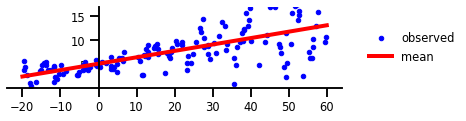

In [12]:
w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())
plt.figure(figsize=[6, 1.5])
plt.plot(x, y, 'b.', label='observed')
plt.plot(x_tst, yhat.mean(), 'r', label="mean", linewidth=4)
plt.ylim(-0., 17)
plt.yticks(np.linspace(0, 15, 4)[1:])
plt.xticks(np.linspace(*x_range, num=9))

ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1 + 1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:])))
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)
[print(np.squeeze(w.numpy())) for w in model.weights]
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.20646156 -0.49349612]
[1.6844304  0.94801193]


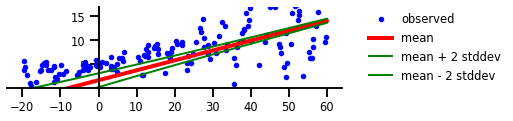

In [22]:
plt.figure(figsize=[6, 1.5])
plt.plot(x, y, 'b.', label='observed')
m = yhat.mean()
s = yhat.stddev()
plt.plot(x_tst, m, 'r', linewidth=4, label='mean')
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev')
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev')
plt.ylim(-0., 17)
plt.yticks(np.linspace(0, 15, 4)[1:])
plt.xticks(np.linspace(*x_range, num=9))

ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

In [44]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t[..., :n], scale=1e-5 + 
                                                                           tf.nn.softplus(c + t[..., n:])), 
                                                                reinterpreted_batch_ndims=1))
    ])

In [45]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t, scale=1), 
                                                                reinterpreted_batch_ndims=1))
    ])

In [46]:
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)
[print(np.squeeze(w.numpy())) for w in model.weights]
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.13079818  5.107244   -4.0899057  -2.529439  ]
[0.14033227 5.1422043 ]


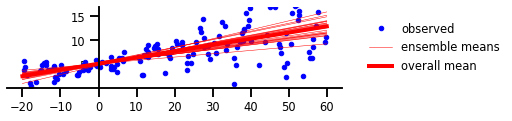

In [47]:
plt.figure(figsize=[6, 1.5])
plt.clf()
plt.plot(x, y, 'b.', label='observed')
yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 25:
        plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth = 0.5)
    avgm += m
plt.plot(x_tst, avgm / len(yhats), 'r', label="overall mean", linewidth=4)
plt.ylim(-0., 17)
plt.yticks(np.linspace(0, 15, 4)[1:])
plt.xticks(np.linspace(*x_range, num=9))

ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

In [50]:
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1 / x.shape[0]),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], 
                                                       scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:])))
])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)
[print(np.squeeze(w.numpy())) for w in model.weights]
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.13556895  2.596266    5.15902     3.6170945  -3.3657796  -0.93094397
 -2.2383664  -0.16321671]
[0.12058035 2.5206943  5.1749477  3.5157092 ]


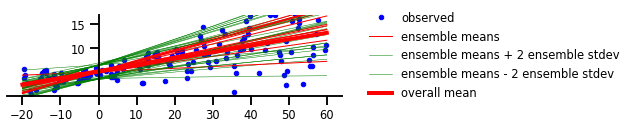

In [54]:
plt.figure(figsize=[6, 1.5])
plt.plot(x, y, 'b.', label='observed')
yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())
    if i < 15:
        plt.plot(x_tst, m, 'r', label='ensemble means' if i == 0 else None, linewidth=1.)
        plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label='ensemble means + 2 ensemble stdev' if i == 0 else None)
        plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label='ensemble means - 2 ensemble stdev' if i == 0 else None)
    avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='overall mean', linewidth=4)
plt.ylim(-0., 17)
plt.yticks(np.linspace(0, 15, 4)[1:])
plt.xticks(np.linspace(*x_range, num=9))

ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

In [62]:
class RBFKernelFn(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RBFKernelFn, self).__init__(**kwargs)
        dtype=kwargs.get('dtype', None)
        self._amplitude = self.add_variable(initializer=tf.constant_initializer(0), dtype=dtype, name='amplitude')
        self._length_scale = self.add_variable(initializer=tf.constant_initializer(0), dtype=dtype, name='length_scale')
    def call(self, x):
        return x
    @property
    def kernel(self):
        return tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=tf.nn.softplus(0.1 * self._amplitude), 
                                                         length_scale=tf.nn.softplus(5. * self._length_scale))

In [63]:
tf.keras.backend.set_floatx('float64')
num_inducing_points = 40
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1]),
    tf.keras.layers.Dense(1, kernel_initializer='ones', use_bias=False),
    tfp.layers.VariationalGaussianProcess(num_inducing_points=num_inducing_points, kernel_provider=RBFKernelFn(),
                                         event_shape=[1], inducing_index_points_initializer=
                                          tf.constant_initializer(np.linspace(*x_range, num=num_inducing_points, 
                                                                              dtype=x.dtype)[..., np.newaxis]), 
                                         unconstrained_observation_noise_variance_initializer=
                                          (tf.constant_initializer(np.array(0.54).astype(x.dtype))))
])
batch_size = 32
loss = lambda y, rv_y: rv_y.variational_loss(y, kl_weight=np.array(batch_size, x.dtype) / x.shape[0])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=loss)
model.fit(x, y, batch_size=batch_size, epochs=1000, verbose=False)
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


<ipython-input-62-a40adaa01ce0>:5: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._amplitude = self.add_variable(initializer=tf.constant_initializer(0), dtype=dtype, name='amplitude')
<ipython-input-62-a40adaa01ce0>:6: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._length_scale = self.add_variable(initializer=tf.constant_initializer(0), dtype=dtype, name='length_scale')
C:\Users\jatin\anaconda3\lib\site-packages\tensorflow_probability\python\distributions\gaussian_process.py:375: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  warnings.warn(


Instructions for updating:
the `jitter` property of `tfd.GaussianProcess` is deprecated; use the `marginal_fn` property instead.


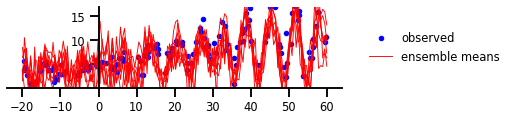

In [65]:
y, x, _ = load_dataset()
plt.figure(figsize=[6, 1.5])
plt.plot(x, y, 'b.', label='observed')
num_samples = 7
for i in range(num_samples):
    sample_ = yhat.sample().numpy()
    plt.plot(x_tst, sample_[..., 0].T, 'r', linewidth=0.9, label='ensemble means' if i == 0 else None)
plt.ylim(-0., 17)
plt.yticks(np.linspace(0, 15, 4)[1:])
plt.xticks(np.linspace(*x_range, num=9))
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc="center left", fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

# Bayesian Gaussian Mixture Model and Hamiltonian MCMC

In [93]:
%matplotlib inline


import functools

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np
import seaborn as sns; sns.set_context('notebook')

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [94]:
class MVNCholPrecisionTriL(tfd.TransformedDistribution):
  """MVN from loc and (Cholesky) precision matrix."""

  def __init__(self, loc, chol_precision_tril, name=None):
    super(MVNCholPrecisionTriL, self).__init__(
        distribution=tfd.Independent(tfd.Normal(tf.zeros_like(loc),
                                                scale=tf.ones_like(loc)),
                                     reinterpreted_batch_ndims=1),
        bijector=tfb.Chain([
            tfb.Shift(shift=loc),
            tfb.Invert(tfb.ScaleMatvecTriL(scale_tril=chol_precision_tril,
                                           adjoint=True)),
        ]),
        name=name)

In [95]:
def compute_sample_stats(d, seed=42, n=int(1e6)):
  x = d.sample(n, seed=seed)
  sample_mean = tf.reduce_mean(x, axis=0, keepdims=True)
  s = x - sample_mean
  sample_cov = tf.linalg.matmul(s, s, adjoint_a=True) / tf.cast(n, s.dtype)
  sample_scale = tf.linalg.cholesky(sample_cov)
  sample_mean = sample_mean[0]
  return [
      sample_mean,
      sample_cov,
      sample_scale,
  ]

dtype = np.float32
true_loc = np.array([1., -1.], dtype=dtype)
true_chol_precision = np.array([[1., 0.],
                                [2., 8.]],
                               dtype=dtype)
true_precision = np.matmul(true_chol_precision, true_chol_precision.T)
true_cov = np.linalg.inv(true_precision)

d = MVNCholPrecisionTriL(
    loc=true_loc,
    chol_precision_tril=true_chol_precision)

[sample_mean, sample_cov, sample_scale] = [
    t.numpy() for t in compute_sample_stats(d)]

print('true mean:', true_loc)
print('sample mean:', sample_mean)
print('true cov:\n', true_cov)
print('sample cov:\n', sample_cov)

Distribution subclass MVNCholPrecisionTriL inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__in

true mean: [ 1. -1.]
sample mean: [ 0.9985562 -1.0000324]
true cov:
 [[ 1.0625   -0.03125 ]
 [-0.03125   0.015625]]
sample cov:
 [[ 1.0653545  -0.03131106]
 [-0.03131106  0.01562333]]


In [96]:
dtype = np.float64
dims = 2
components = 3
num_samples = 1000
bgmm = tfd.JointDistributionNamed(dict(
  mix_probs=tfd.Dirichlet(
    concentration=np.ones(components, dtype) / 10.),
  loc=tfd.Independent(
    tfd.Normal(
        loc=np.stack([
            -np.ones(dims, dtype),
            np.zeros(dims, dtype),
            np.ones(dims, dtype),
        ]),
        scale=tf.ones([components, dims], dtype)),
    reinterpreted_batch_ndims=2),
  precision=tfd.Independent(
    tfd.WishartTriL(
        df=5,
        scale_tril=np.stack([np.eye(dims, dtype=dtype)]*components),
        input_output_cholesky=True),
    reinterpreted_batch_ndims=1),
  s=lambda mix_probs, loc, precision: tfd.Sample(tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(probs=mix_probs),
      components_distribution=MVNCholPrecisionTriL(
          loc=loc,
          chol_precision_tril=precision)),
      sample_shape=num_samples)
))

In [97]:
def joint_log_prob(observations, mix_probs, loc, chol_precision):
  """BGMM with priors: loc=Normal, precision=Inverse-Wishart, mix=Dirichlet.

  Args:
    observations: `[n, d]`-shaped `Tensor` representing Bayesian Gaussian
      Mixture model draws. Each sample is a length-`d` vector.
    mix_probs: `[K]`-shaped `Tensor` representing random draw from
      `Dirichlet` prior.
    loc: `[K, d]`-shaped `Tensor` representing the location parameter of the
      `K` components.
    chol_precision: `[K, d, d]`-shaped `Tensor` representing `K` lower
      triangular `cholesky(Precision)` matrices, each being sampled from
      a Wishart distribution.

  Returns:
    log_prob: `Tensor` representing joint log-density over all inputs.
  """
  return bgmm.log_prob(
      mix_probs=mix_probs, loc=loc, precision=chol_precision, s=observations)

In [98]:
true_loc = np.array([[-2., -2],
                     [0, 0],
                     [2, 2]], dtype)
random = np.random.RandomState(seed=43)

true_hidden_component = random.randint(0, components, num_samples)
observations = (true_loc[true_hidden_component] +
                random.randn(num_samples, dims).astype(dtype))

In [99]:
unnormalized_posterior_log_prob = functools.partial(joint_log_prob, observations)

In [101]:
initial_state = [
    tf.fill([components],
            value=np.array(1. / components, dtype),
            name='mix_probs'),
    tf.constant(np.array([[-2., -2],
                          [0, 0],
                          [2, 2]], dtype),
                name='loc'),
    tf.linalg.eye(dims, batch_shape=[components], dtype=dtype, name='chol_precision'),
]

In [102]:
unconstraining_bijectors = [
    tfb.SoftmaxCentered(),
    tfb.Identity(),
    tfb.Chain([
        tfb.TransformDiagonal(tfb.Softplus()),
        tfb.FillTriangular(),
    ])]

In [103]:
@tf.function(autograph=False)
def sample():
  return tfp.mcmc.sample_chain(
    num_results=2000,
    num_burnin_steps=500,
    current_state=initial_state,
    kernel=tfp.mcmc.SimpleStepSizeAdaptation(
        tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                target_log_prob_fn=unnormalized_posterior_log_prob,
                 step_size=0.065,
                 num_leapfrog_steps=5),
            bijector=unconstraining_bijectors),
         num_adaptation_steps=400),
    trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted)

[mix_probs, loc, chol_precision], is_accepted = sample()

Distribution subclass MVNCholPrecisionTriL inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__in

Distribution subclass MVNCholPrecisionTriL inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__in

Distribution subclass MVNCholPrecisionTriL inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__in

Distribution subclass MVNCholPrecisionTriL inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__in

Distribution subclass MVNCholPrecisionTriL inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__in

Distribution subclass MVNCholPrecisionTriL inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__in

Distribution subclass MVNCholPrecisionTriL inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__in

Distribution subclass MVNCholPrecisionTriL inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__in

Distribution subclass MVNCholPrecisionTriL inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__in

Distribution subclass MVNCholPrecisionTriL inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__in

Distribution subclass MVNCholPrecisionTriL inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__in

In [104]:
acceptance_rate = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32)).numpy()
mean_mix_probs = tf.reduce_mean(mix_probs, axis=0).numpy()
mean_loc = tf.reduce_mean(loc, axis=0).numpy()
mean_chol_precision = tf.reduce_mean(chol_precision, axis=0).numpy()
precision = tf.linalg.matmul(chol_precision, chol_precision, transpose_b=True)

In [105]:
print('accepteance rate:', acceptance_rate)
print('avg mix probs:', mean_mix_probs)
print('avg loc:\n', mean_loc)
print('avg chol(precision):\n', mean_chol_precision)

accepteance rate: 0.6975
avg mix probs: [0.27646638 0.5609961  0.16253752]
avg loc:
 [[-1.9518962  -2.06419437]
 [ 0.27942543  0.23227409]
 [ 2.08733296  2.46498778]]
avg chol(precision):
 [[[ 1.03357833  0.        ]
  [ 0.09520711  1.05041776]]

 [[ 0.78791641  0.        ]
  [-0.42655009  0.84186057]]

 [[ 1.22663427  0.        ]
  [ 0.68994869  1.43183357]]]


C:\Users\jatin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\jatin\anaconda3\lib\site-packages\seaborn\distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\jatin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\jatin\anaconda3\lib\site-packages\seaborn\distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in fav

Text(0.5, 1.0, 'KDE of loc draws')

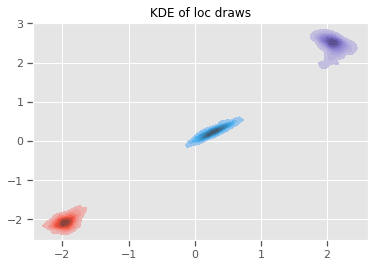

In [106]:
loc_ = loc.numpy()
ax = sns.kdeplot(loc_[:, 0, 0], loc_[:, 0, 1], shade=True, shade_lowest=False)
ax = sns.kdeplot(loc_[:, 1, 0], loc_[:, 1, 1], shade=True, shade_lowest=False)
ax = sns.kdeplot(loc_[:, 2, 0], loc_[:, 2, 1], shade=True, shade_lowest=False)
plt.title('KDE of loc draws')

# Bayesian Switchpoint Analysis

In [1]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 8)
%config InlineBackend.figure_format = "retina"
import numpy as np
import pandas as pd

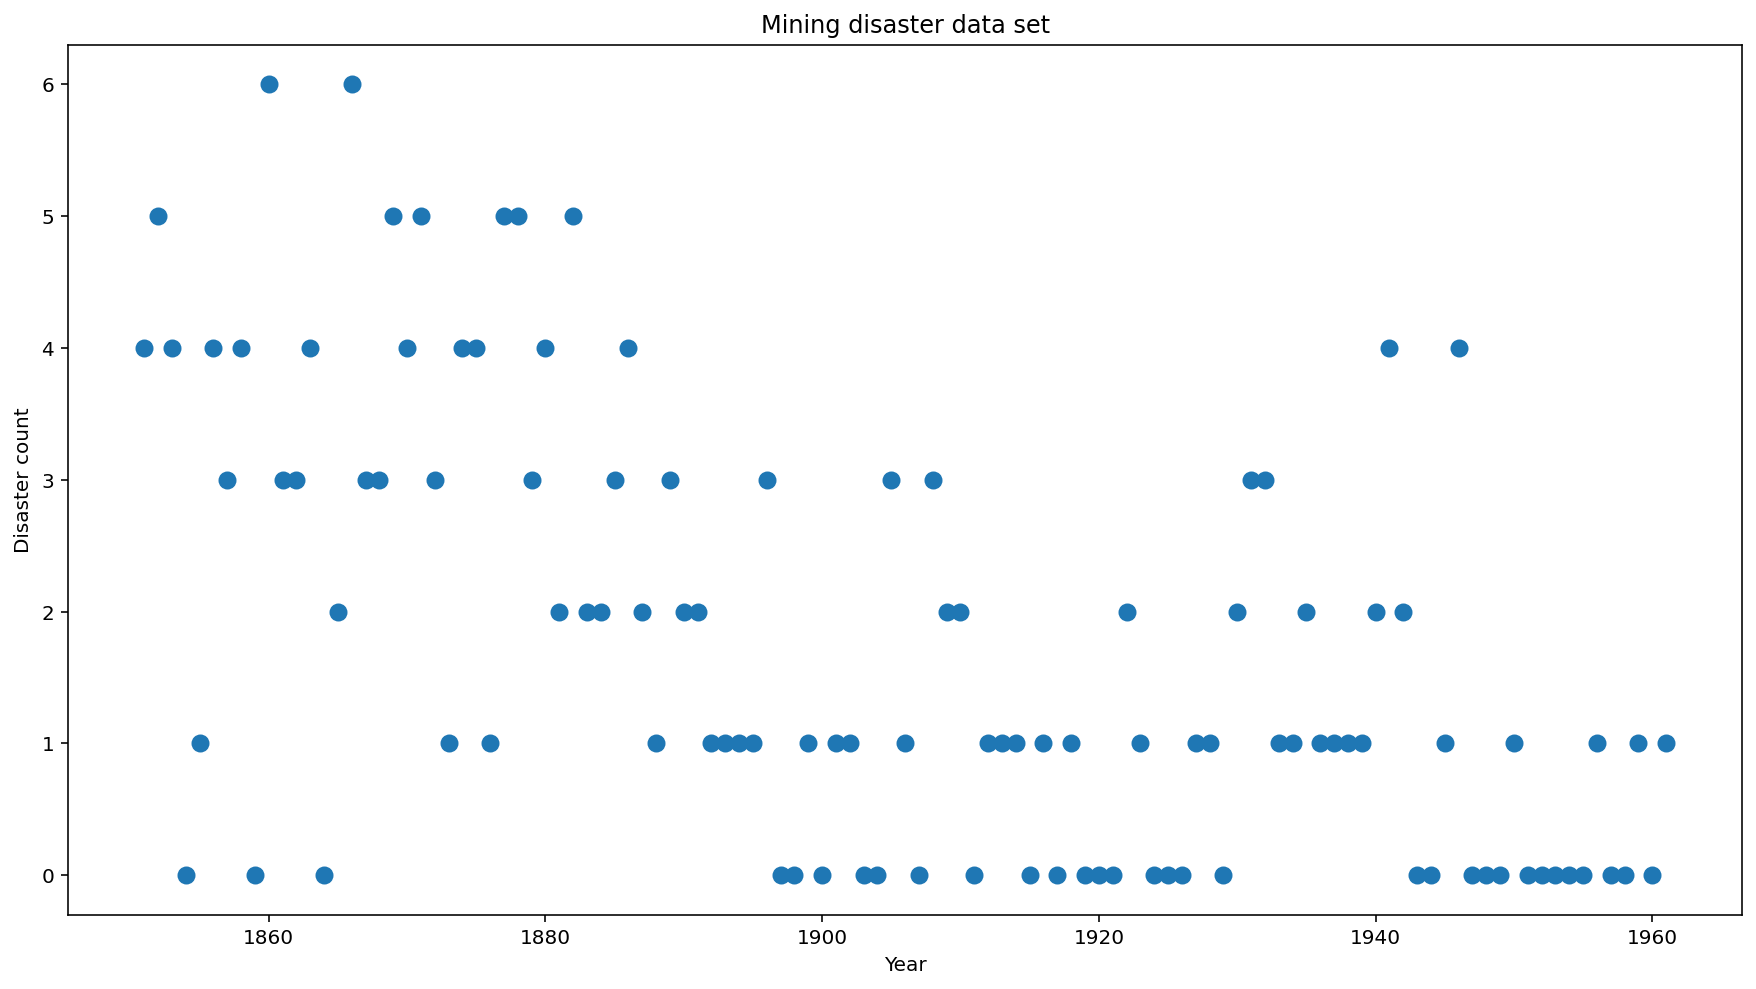

In [3]:
disaster_data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 
                         3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                         2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                         1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                         0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                         3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                         0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)
plt.plot(years, disaster_data, 'o', markersize=8)
plt.ylabel('Disaster count')
plt.xlabel('Year')
plt.title('Mining disaster data set')
plt.show()

In [5]:
def disaster_count_model(disaster_rate_fn):
    disaster_count = tfd.JointDistributionNamed(dict(e = tfd.Exponential(rate=1.),
                                                    l = tfd.Exponential(rate=1.),
                                                    s = tfd.Uniform(0., high=len(years)), 
                                                    d_t = lambda s, l, e: tfd.Independent(tfd.Poisson(rate=
                                                            disaster_rate_fn(np.arange(len(years)), s, l, e)), 
                                                            reinterpreted_batch_ndims=1)))
    return disaster_count

def disaster_rate_switch(ys, s, l, e):
    return tf.where(ys < s, l, e)

def disaster_rate_sigmoid(ys, s, l, e):
    return e + tf.sigmoid(ys - s) * (l - e)

model_switch = disaster_count_model(disaster_rate_switch)
model_sigmoid = disaster_count_model(disaster_rate_sigmoid)

In [7]:
def target_log_prob_fn(model, s, e, l):
    return model.log_prob(s=s, e=e, l=l, d_t=disaster_data)
models = [model_switch, model_sigmoid]
print([target_log_prob_fn(m, 40., 3., .9).numpy() for m in models])
print([target_log_prob_fn(m, 60., 1., 5.).numpy() for m in models])
print([target_log_prob_fn(m, -10., 1., 1.).numpy() for m in models])

[-313.07996, -176.28716]
[-238.3215, -366.88162]
[-inf, -inf]


In [11]:
num_results = 10000
num_burnin_steps = 3000
@tf.function(autograph=False, jit_compile=True)
def makechain(target_log_prob_fn):
    kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=target_log_prob_fn, step_size=0.05, 
                                                      num_leapfrog_steps=3),
        bijector=[tfb.Sigmoid(low=0, high=tf.cast(len(years), dtype=tf.float32)),
                 tfb.Softplus(), 
                 tfb.Softplus()]
    )
    kernel = tfp.mcmc.SimpleStepSizeAdaptation(inner_kernel=kernel, num_adaptation_steps=int(0.8 * num_burnin_steps))
    states = tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, current_state=[
        tf.ones([], name='init_switchpoint'),
        tf.ones([], name='init_early_disaster_rate'),
        tf.ones([], name='init_late_disaster_rate')
    ],
                                   trace_fn=None, kernel=kernel
                                  )
    return states

In [13]:
switch_samples = [s.numpy() for s in makechain(lambda *args: target_log_prob_fn(model_switch, *args))]
sigmoid_samples = [s.numpy() for s in makechain(lambda *args: target_log_prob_fn(model_sigmoid, *args))]
switchpoint, early_disaster_rate, late_disaster_rate = zip(switch_samples, sigmoid_samples)

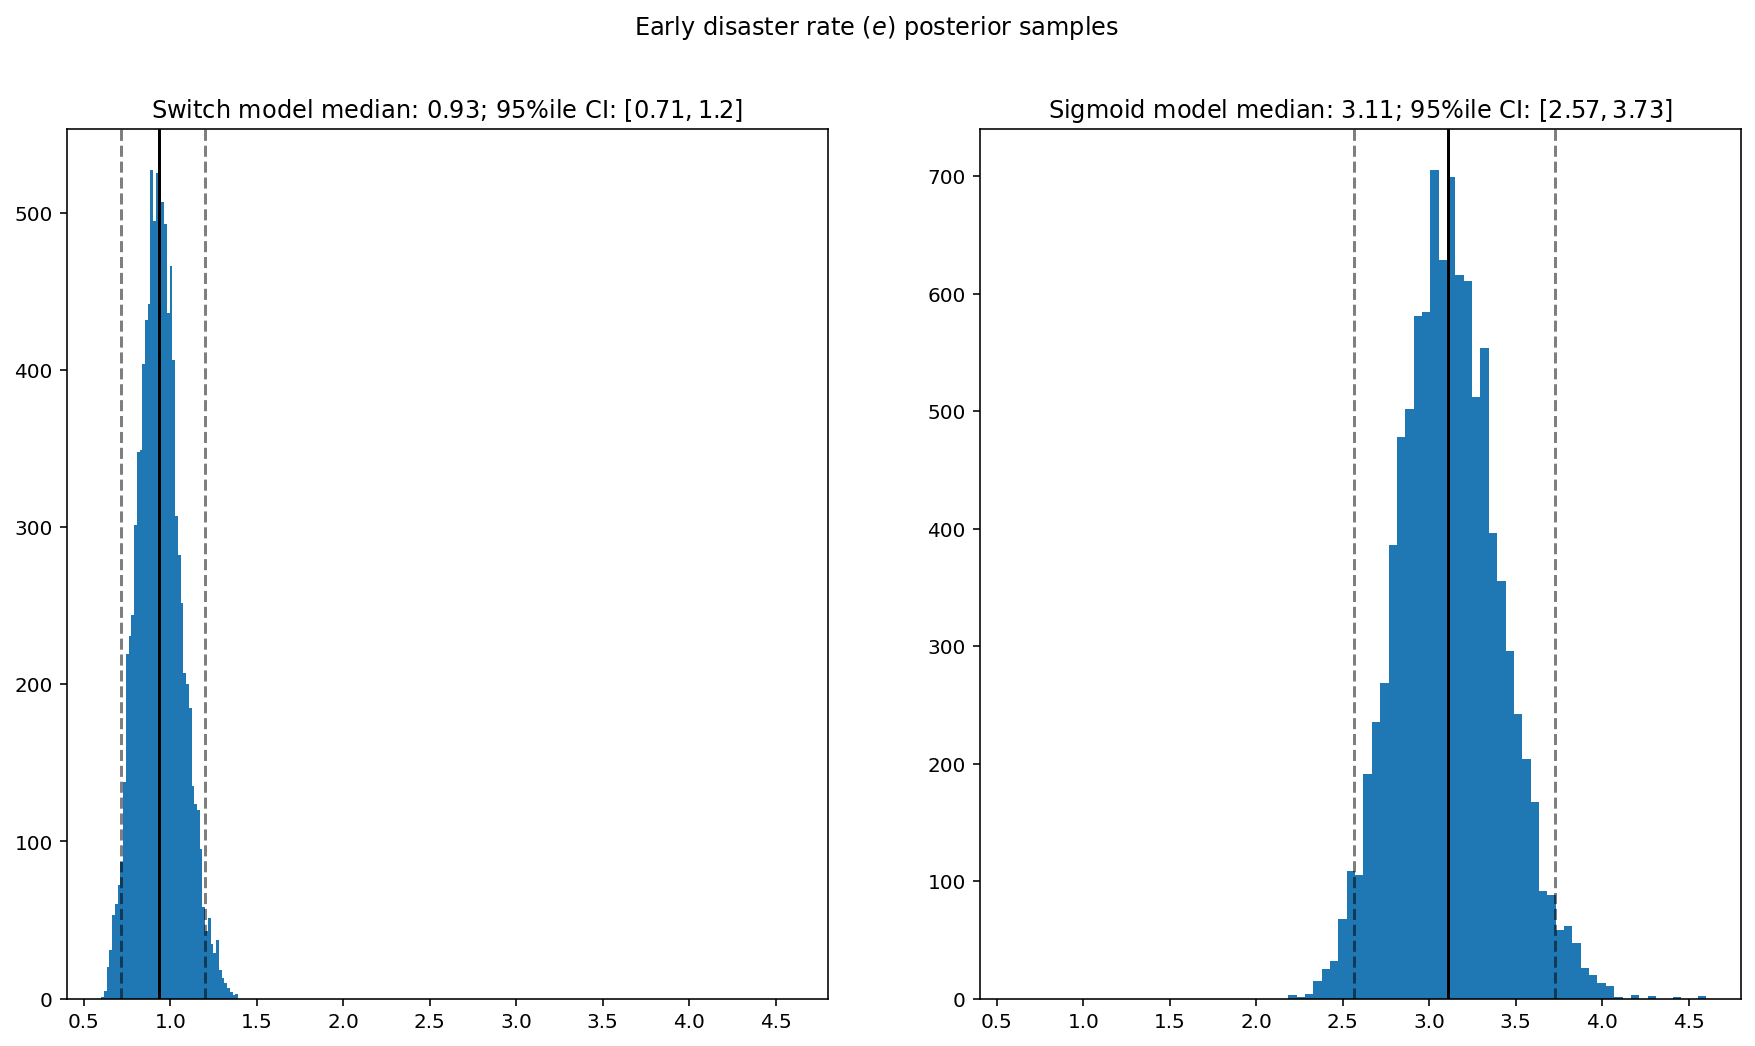

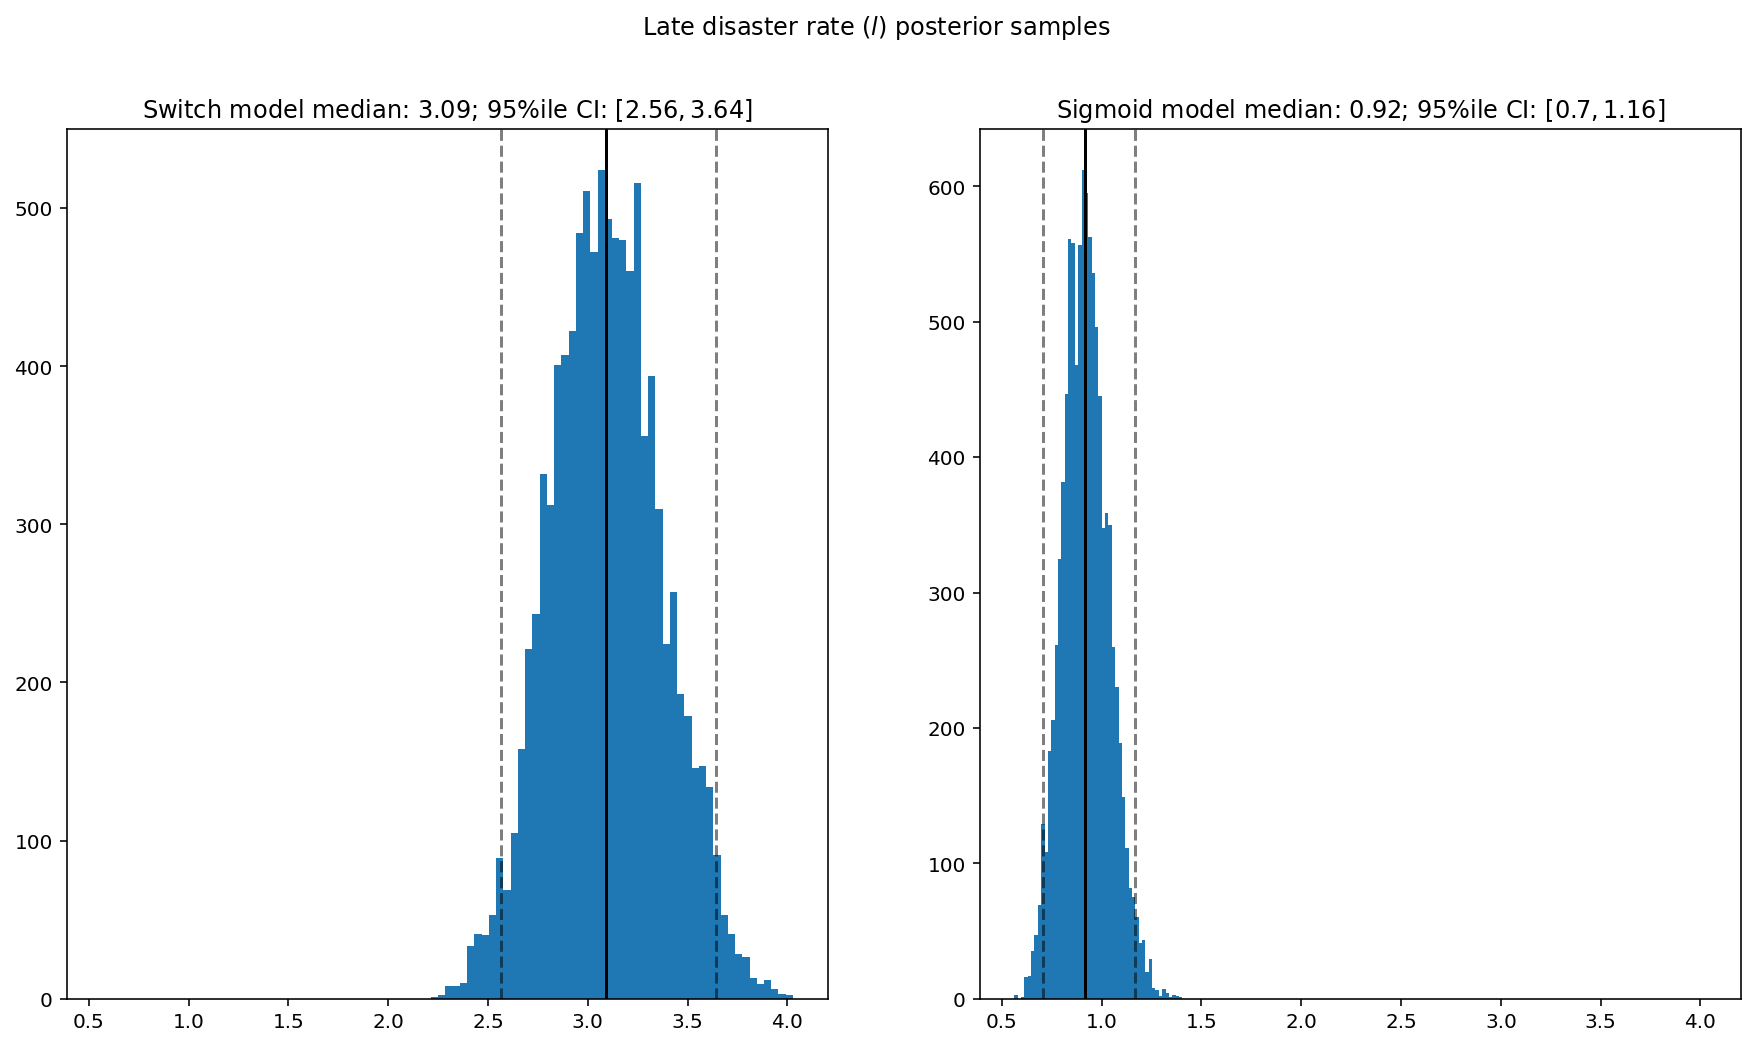

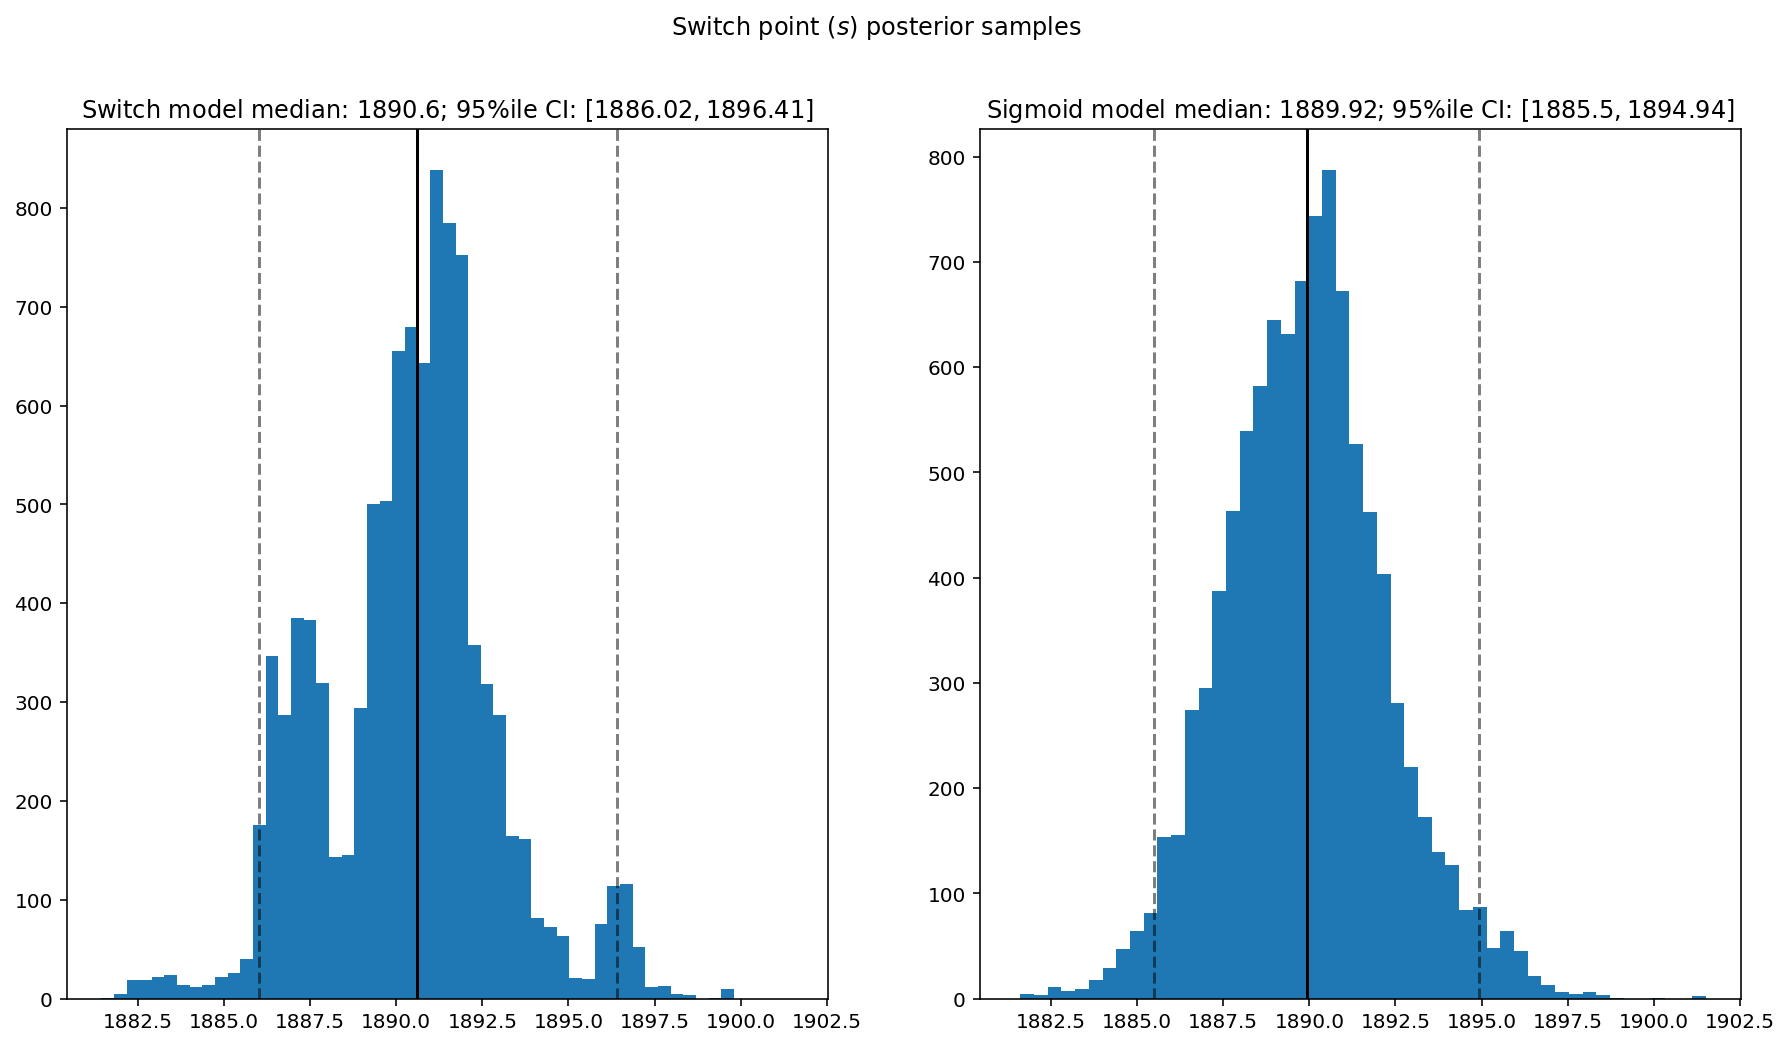

In [15]:
def _desc(v):
    return 'median: {}; 95%ile CI: $[{}, {}$]'.format(*np.round(np.percentile(v, [50, 2.5, 97.5]), 2))

for t, v in [
    ('Early disaster rate ($e$) posterior samples', early_disaster_rate),
    ('Late disaster rate ($l$) posterior samples', late_disaster_rate),
    ('Switch point ($s$) posterior samples', years[0] + switchpoint)
]:
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
    for (m, i) in (('Switch', 0), ('Sigmoid', 1)):
        a = ax[i]
        a.hist(v[i], bins=50)
        a.axvline(x=np.percentile(v[i], 50), color='k')
        a.axvline(x=np.percentile(v[i], 2.5), color='k', ls='dashed', alpha=.5)
        a.axvline(x=np.percentile(v[i], 97.5), color='k', ls='dashed', alpha=.5)
        a.set_title(m + ' model ' + _desc(v[i]))
    fig.suptitle(t)
    plt.show()

# Eight Schools

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
import warnings
tf.enable_v2_behavior()
plt.style.use("ggplot")
warnings.filterwarnings('ignore')

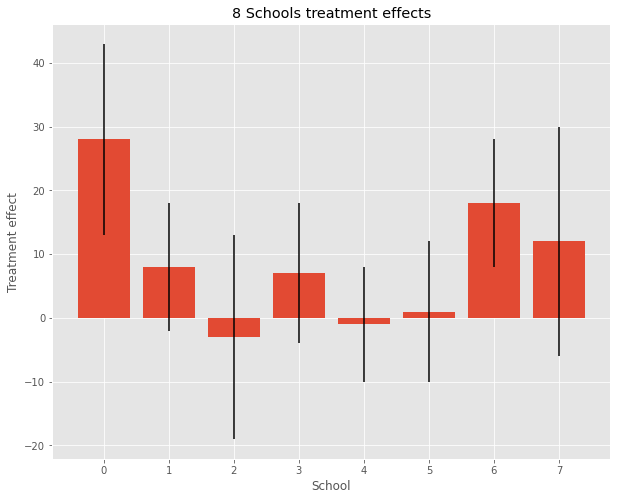

In [4]:
num_schools = 8
treatment_effects = np.array([28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)
treatment_stddevs = np.array([15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)
fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()

In [8]:
model = tfd.JointDistributionSequential([
    tfd.Normal(loc=0., scale=10., name="avg_effect"),
    tfd.Normal(loc=5., scale=1., name="avg_stddev"),
    tfd.Independent(tfd.Normal(loc=tf.zeros(num_schools), scale=tf.ones(num_schools), name="school_effects_standard"), 
                   reinterpreted_batch_ndims=1),
    lambda school_effects_standard, avg_stddev, avg_effect: (tfd.Independent(tfd.Normal(loc=
                                                                                        (avg_effect[..., tf.newaxis] +
                            tf.exp(avg_stddev[..., tf.newaxis]) * school_effects_standard), scale=treatment_stddevs),
                                                                            name="treatment_effects", 
                                                                             reinterpreted_batch_ndims=1))
])
def target_log_prob_fn(avg_effect, avg_stddev, school_effects_standard):
    return model.log_prob((avg_effect, avg_stddev, school_effects_standard, treatment_effects))

In [9]:
num_results = 5000
num_burnin_steps = 3000
@tf.function(autograph=False, jit_compile=True)
def do_sampling():
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, current_state=[
        tf.zeros([], name="init_avg_effect"),
        tf.zeros([], name="init_avg_stddev"),
        tf.ones([num_schools], name="init_school_effects_standard")
    ],
                                kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=target_log_prob_fn, 
                                                                        step_size=0.4, num_leapfrog_steps=3))
states, kernel_results = do_sampling()
avg_effect, avg_stddev, school_effects_standard = states
school_effects_samples = (avg_effect[:, np.newaxis] + np.exp(avg_stddev)[:, np.newaxis] * school_effects_standard)
num_accepted = np.sum(kernel_results.is_accepted)
print("Acceptance rate: {}".format(num_accepted / num_results))

Acceptance rate: 0.6264


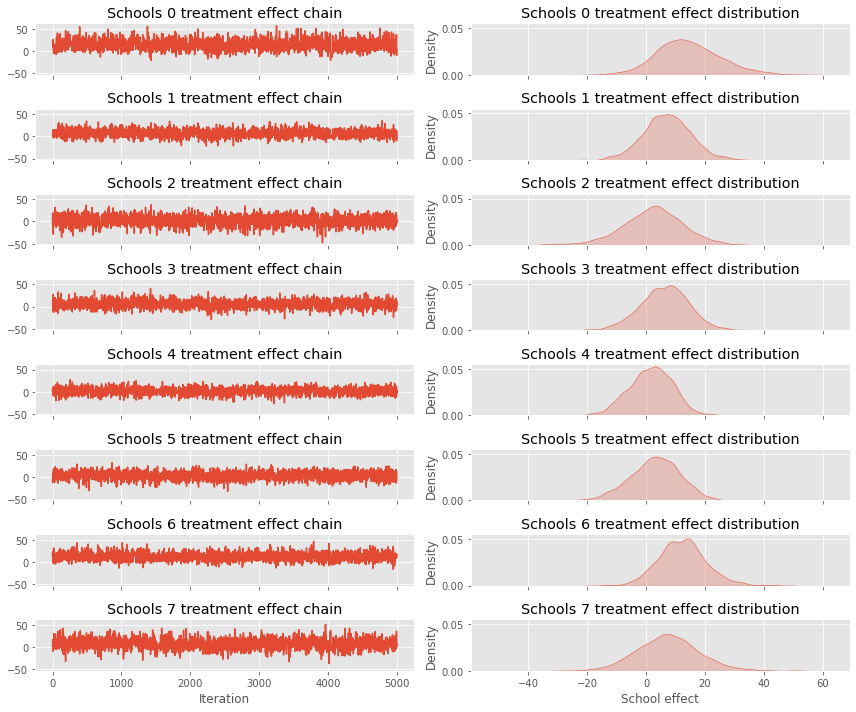

In [10]:
fig, axes = plt.subplots(8, 2, sharex='col', sharey='col')
fig.set_size_inches(12, 10)
for i in range(num_schools):
    axes[i][0].plot(school_effects_samples[:, i].numpy())
    axes[i][0].title.set_text("Schools {} treatment effect chain".format(i))
    sns.kdeplot(school_effects_samples[:, i].numpy(), ax=axes[i][1], shade=True)
    axes[i][1].title.set_text("Schools {} treatment effect distribution".format(i))
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()

In [12]:
print("E[avg_effect] = {}".format(np.mean(avg_effect)))
print("E[avg_stddev] = {}".format(np.mean(avg_stddev)))
print("E[school_effect_standard] = ")
print(np.mean(school_effects_standard[:, ]))
print("E[school_effect] = ")
print(np.mean(school_effects_samples[:, ], axis=0))

E[avg_effect] = 4.971420764923096
E[avg_stddev] = 2.453214645385742
E[school_effect_standard] = 
0.12081687
E[school_effect] = 
[14.361338   7.017982   2.1304092  6.1470757  1.5497531  2.9108596
 12.2188425  7.3854756]


In [14]:
school_effects_low = np.array([np.percentile(school_effects_samples[:, i], 2.5) for i in range(num_schools)])
school_effects_med = np.array([np.percentile(school_effects_samples[:, i], 50) for i in range(num_schools)])
school_effects_hi = np.array([np.percentile(school_effects_samples[:, i], 97.5) for i in range(num_schools)])

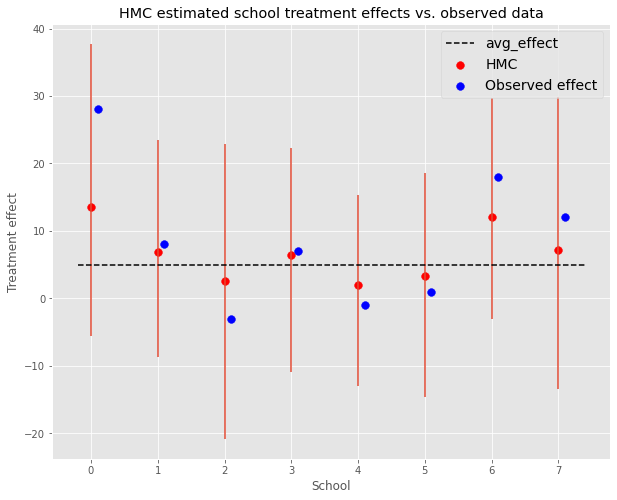

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
ax.scatter(np.array(range(num_schools)), school_effects_med, color='red', s=60)
ax.scatter(np.array(range(num_schools)) + 0.1, treatment_effects, color="blue", s=60)
plt.plot([-0.2, 7.4], [np.mean(avg_effect), np.mean(avg_effect)], 'k', linestyle='--')
ax.errorbar(np.array(range(8)), school_effects_med, yerr=[
    school_effects_med - school_effects_low, school_effects_hi - school_effects_med
], fmt='none')
ax.legend(("avg_effect", 'HMC', "Observed effect"), fontsize=14)
plt.xlabel('School')
plt.ylabel('Treatment effect')
plt.title('HMC estimated school treatment effects vs. observed data')
fig.set_size_inches(10, 8)
plt.show()

In [17]:
print("Inferred posterior mean: {0:.2f}".format(np.mean(school_effects_samples[:, ])))
print("Inferred posterior mean se: {0:.2f}".format(np.std(school_effects_samples[:, ])))

Inferred posterior mean: 6.72
Inferred posterior mean se: 10.20


In [19]:
sample_shape = [5000]
_, _, _, predictive_treatment_effects = model.sample(value=(tf.broadcast_to(np.mean(avg_effect, 0), sample_shape),
                                                           tf.broadcast_to(np.mean(avg_stddev, 0), sample_shape), 
                                                           tf.broadcast_to(np.mean(school_effects_standard, 0),
                                                                          sample_shape + [num_schools]), None))


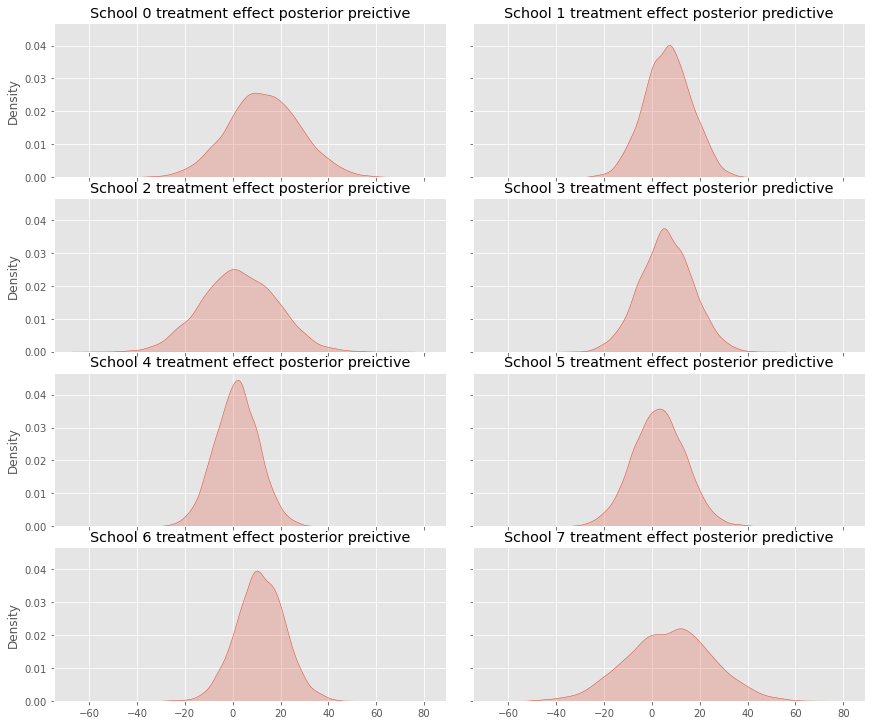

In [21]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 10)
fig.tight_layout()
for i, ax in enumerate(axes):
    sns.kdeplot(predictive_treatment_effects[:, 2 * i].numpy(), ax=ax[0], shade=True)
    ax[0].title.set_text("School {} treatment effect posterior preictive".format(2 * i))
    sns.kdeplot(predictive_treatment_effects[:, 2 * i + 1].numpy(), ax=ax[1], shade=True)
    ax[1].title.set_text("School {} treatment effect posterior predictive".format(2 * i + 1))
plt.show()

In [22]:
prediction = np.mean(predictive_treatment_effects, axis=0)

In [23]:
treatment_effects - prediction

array([15.152224 ,  1.3567319, -5.4638944,  1.0816402, -2.5587554,
       -1.8868906,  6.4881287,  4.802446 ], dtype=float32)

In [24]:
residuals = treatment_effects - predictive_treatment_effects

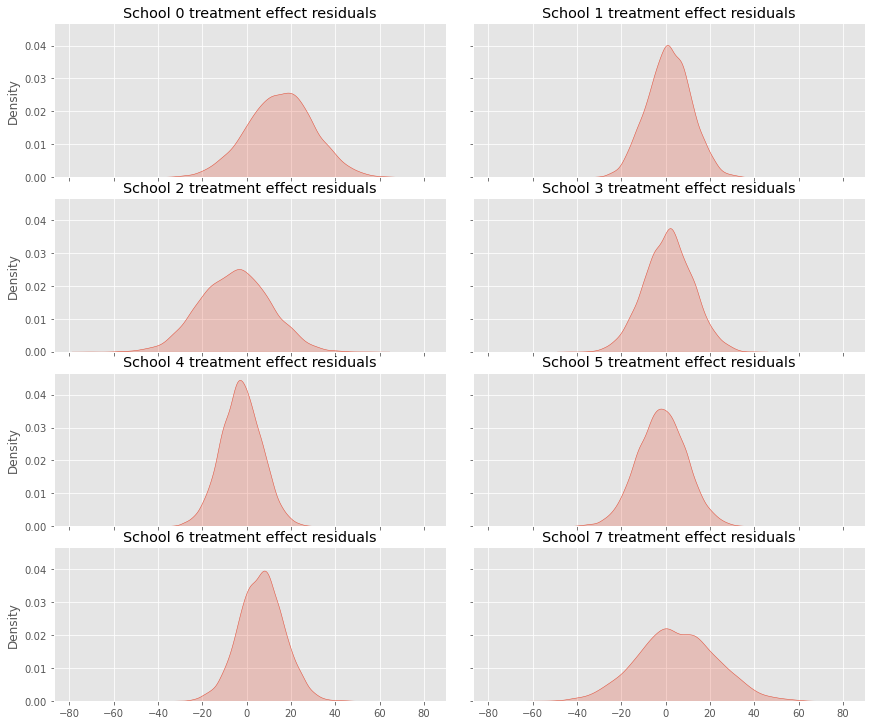

In [25]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 10)
fig.tight_layout()
for i, ax in enumerate(axes):
    sns.kdeplot(residuals[:, 2 * i].numpy(), ax=ax[0], shade=True)
    ax[0].title.set_text("School {} treatment effect residuals".format(2 * i))
    sns.kdeplot(residuals[:, 2 * i + 1].numpy(), ax=ax[1], shade=True)
    ax[1].title.set_text("School {} treatment effect residuals".format(2 * i + 1))
plt.show()

# Factorial Mixture 

In [26]:
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
tfd = tfp.distributions
try:
    tf.enable_eager_execution()
except:
    pass

In [28]:
num_vars = 2
var_dim = 1
num_components = 3
sigma = 5e-2
component_mean = tfd.Uniform().sample([num_vars, num_components, var_dim])
factorial_mog = tfd.Independent(tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=
                                tf.zeros([num_vars, num_components])), 
                                components_distribution=tfd.MultivariateNormalDiag(loc=component_mean, 
                                scale_diag=[sigma])), reinterpreted_batch_ndims=1)

Text(0.5, 1.0, 'Density of factorial mixture of Gaussians')

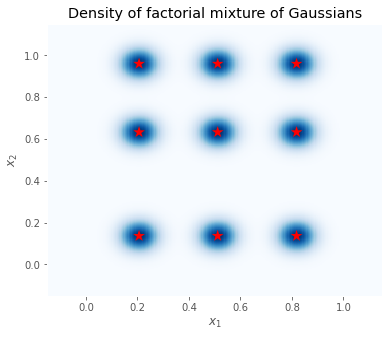

In [29]:
plt.figure(figsize=(6, 5))
nx = 250
x = np.linspace(-3 * sigma, 1 + 3 * sigma, nx).astype('float32')
vals = tf.reshape(tf.stack(np.meshgrid(x, x), axis=2),(-1, num_vars, var_dim))
probs = factorial_mog.prob(vals).numpy().reshape(nx, nx)
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("Blues", 256))
p = plt.pcolor(x, x, probs, cmap=cmap)
ax = plt.axis('tight')

means_np = component_mean.numpy().squeeze()
for mu_x in means_np[0]:
    for mu_y in means_np[1]:
        plt.scatter(mu_x, mu_y, s=150, marker="*", c='r', edgecolor='none')
plt.axis(ax)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Density of factorial mixture of Gaussians')

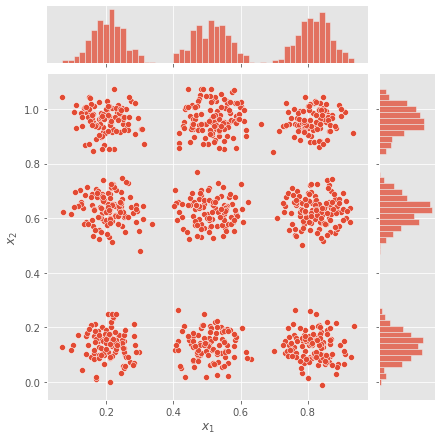

In [30]:
samples = factorial_mog.sample(1000).numpy()
g = sns.jointplot(x=samples[:, 0, 0], y = samples[:, 1, 0], kind="scatter", marginal_kws=dict(bins=50))
g.set_axis_labels("$x_1$", "$x_2$")


# Copulas Primer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

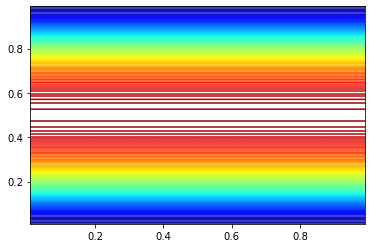

In [6]:
class GaussianCopulaTriL(tfd.TransformedDistribution):
    def __init__(self, loc, scale_tril):
        super(GaussianCopulaTriL, self).__init__(distribution=tfd.MultivariateNormalTriL(loc=loc, 
                                        scale_tril=scale_tril), bijector=tfb.NormalCDF(), validate_args=False, 
                                                name="GaussianColulaTriLUniform")
unit_interval = np.linspace(0.01, 0.99, num=200, dtype=np.float32)
x_grid, y_grid = np.meshgrid(unit_interval, unit_interval)
coordinates = np.concatenate([
    x_grid[..., np.newaxis],
    y_grid[..., np.newaxis]
], axis=-1)
pdf = GaussianCopulaTriL(loc=[0., 0.], scale_tril=[[1., 0.8], [0., 0.6]]).prob(coordinates)
plt.contour(x_grid, y_grid, pdf, 100, cmap=plt.cm.jet)

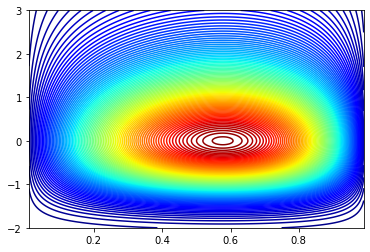

In [7]:
a = 2.0
b = 2.0
gloc = 0.
gscale = 1.
x = tfd.Kumaraswamy(a, b)
y = tfd.Gumbel(loc=gloc, scale=gscale)
x_axis_interval = np.linspace(0.01, 0.99, num=200, dtype=np.float32)
y_axis_interval = np.linspace(-2., 3., num=200, dtype=np.float32)
x_grid, y_grid = np.meshgrid(x_axis_interval, y_axis_interval)
pdf = x.prob(x_grid) * y.prob(y_grid)
plt.contour(x_grid, y_grid, pdf, 100, cmap=plt.cm.jet)

In [12]:
class WarpedGaussianCopula(tfd.TransformedDistribution):
    def __init__(self, loc, scale_tril, marginal_bijectors, block_sizes=None):
        super(WarpedGaussianCopula, self).__init__(distribution=GaussianCopulaTriL(loc=loc, scale_tril=scale_tril),
                    bijector=tfb.Blockwise(bijectors=marginal_bijectors, block_sizes=block_sizes), validate_args=False,
                                                  name="GaussianCopula")

In [13]:
coordinates = np.concatenate([
    x_grid[..., np.newaxis], y_grid[..., np.newaxis]
], -1)

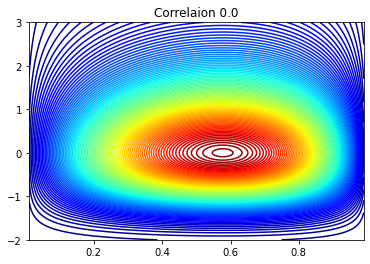

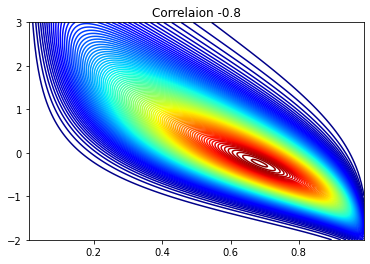

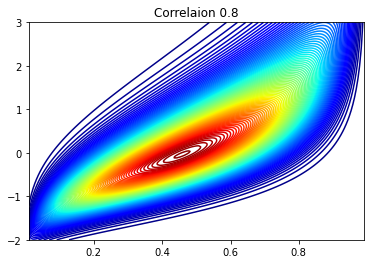

In [14]:
def create_gaussian_copula(correlation):
    return WarpedGaussianCopula(loc=[0., 0.], scale_tril=[[1., 0.], [correlation, tf.sqrt(1. - correlation ** 2)]],
                               marginal_bijectors = [tfb.Invert(tfb.KumaraswamyCDF(a, b)), tfb.Invert(tfb.GumbelCDF(
                               loc=0., scale=1.))])
correlations = [0., -0.8, 0.8]
copulas = []
probs = []
for correlation in correlations:
    copula = create_gaussian_copula(correlation)
    copulas.append(copula)
    probs.append(copula.prob(coordinates))
for correlation, copula_prob in zip(correlations, probs):
    plt.figure()
    plt.contour(x_grid, y_grid, copula_prob, 100, cmap=plt.cm.jet)
    plt.title('Correlaion {}'.format(correlation))

Distribution subclass GaussianCopulaTriL inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init

Distribution subclass GaussianCopulaTriL inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init

Distribution subclass GaussianCopulaTriL inherits `_parameter_properties from its parent (TransformedDistribution)
while also redefining `__init__`. The inherited annotations cover the following
parameters: dict_keys(['distribution', 'bijector']). It is likely that these do not match the subclass parameters.
This may lead to errors when computing batch shapes, slicing into batch
dimensions, calling `.copy()`, flattening the distribution as a CompositeTensor
(e.g., when it is passed or returned from a `tf.function`), and possibly other
cases. The recommended pattern for distribution subclasses is to define a new
`_parameter_properties` method with the subclass parameters, and to store the
corresponding parameter values as `self._parameters` in `__init__`, after
calling the superclass constructor:

```
class MySubclass(tfd.SomeDistribution):

  def __init__(self, param_a, param_b):
    parameters = dict(locals())
    # ... do subclass initialization ...
    super(MySubclass, self).__init

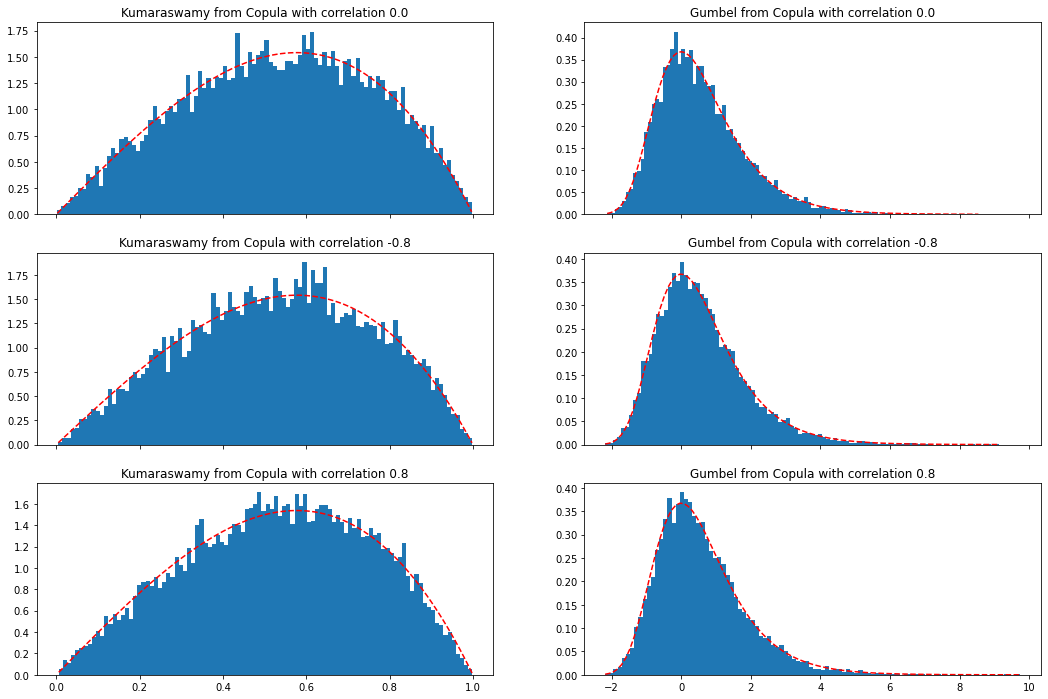

In [16]:
def kumaraswamy_pdf(x):
    return tfd.Kumaraswamy(a, b).prob(np.float32(x))

def gumbel_pdf(x):
    return tfd.Gumbel(gloc, gscale).prob(np.float32(x))

copula_samples = []
for copula in copulas:
    copula_samples.append(copula.sample(10000))
plot_rows = len(correlations)
plot_cols = 2
fig, axes = plt.subplots(plot_rows, plot_cols, sharex='col', figsize=(18, 12))
for i, (correlation, copula_sample) in enumerate(zip(correlations, copula_samples)):
    k = copula_sample[..., 0].numpy()
    g = copula_sample[..., 1].numpy()
    
    _, bins, _ = axes[i, 0].hist(k, bins=100, density=True)
    axes[i, 0].plot(bins, kumaraswamy_pdf(bins), 'r--')
    axes[i, 0].set_title('Kumaraswamy from Copula with correlation {}'.format(correlation))
    
    _, bins, _ = axes[i, 1].hist(g, bins=100, density=True)
    axes[i, 1].plot(bins, gumbel_pdf(bins), 'r--')
    axes[i, 1].set_title('Gumbel from Copula with correlation {}'.format(correlation))

In [18]:
copula_sample

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[ 0.05612314, -1.1240995 ],
       [ 0.14828785, -0.8974598 ],
       [ 0.80083156,  1.5976983 ],
       ...,
       [ 0.15008175, -0.78401226],
       [ 0.53789395, -0.088178  ],
       [ 0.6589609 ,  0.3089885 ]], dtype=float32)>

# Gaussian Process Latent Variable Models

In [20]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['axes']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [21]:
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
N = 1000
small_x_train = x_train[:N, ...].astype(np.float64) / 256.
small_y_train = y_train[:N]

In [27]:
unconstrained_amplitude = tf.Variable(np.float64(1.), name='amplitude')
unconstrained_length_scale = tf.Variable(np.float64(1.), name='length_scale')
unconstrained_observation_noise = tf.Variable(np.float64(1.), name="observation_noise")

In [28]:
observations_ = small_x_train.reshape(N, -1).transpose()
init_ = np.random.normal(size=(N, 2))
latent_index_points = tf.Variable(init_, name='latent_index_points')

In [29]:
EPS = np.finfo(np.float64).eps
def create_kernel():
    amplitude = tf.math.softplus(EPS + unconstrained_amplitude)
    length_scale = tf.math.softplus(EPS + unconstrained_length_scale)
    kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)
    return kernel

def loss_fn():
    observation_noise_variance =tf.math.softplus(EPS + unconstrained_observation_noise)
    gp = tfd.GaussianProcess(kernel=create_kernel(),
                            index_points=latent_index_points, 
                            observation_noise_variance=observation_noise_variance)
    log_probs = gp.log_prob(observations_, name='log_prob')
    return -tf.reduce_mean(log_probs)

trainable_variables = [unconstrained_amplitude, unconstrained_length_scale, unconstrained_observation_noise,
                      latent_index_points]
optimizer = tf.optimizers.Adam(learning_rate=1.0)
@tf.function(autograph=False, jit_compile=True)
def train_model():
    with tf.GradientTape() as tape:
        loss_value = loss_fn()
    grads = tape.gradient(loss_value, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss_value

In [30]:
num_iters = 100
log_interval = 20
lips = np.zeros((num_iters, N, 2), np.float64)
for i in range(num_iters):
    loss = train_model()
    lips[i] = latent_index_points.numpy()
    if i % log_interval == 0 or i + 1 == num_iters:
        print("Loss at step %d: %f" % (i, loss))

Loss at step 0: 1108.362768
Loss at step 20: -162.434885
Loss at step 40: -265.445943
Loss at step 60: -285.331139
Loss at step 80: -289.897582
Loss at step 99: -291.127022


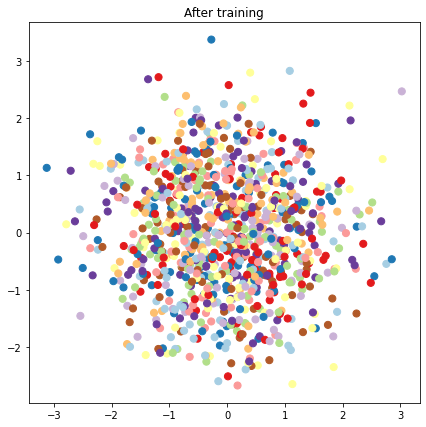

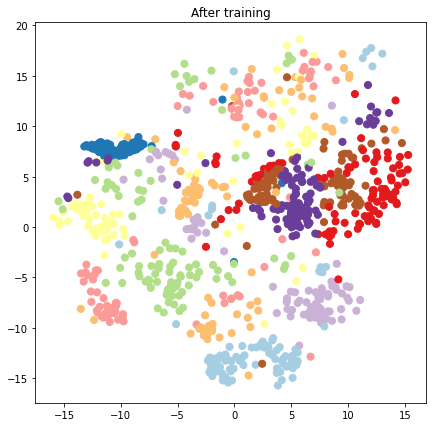

In [31]:
plt.figure(figsize=(7, 7))
plt.title("After training")
plt.grid(False)
plt.scatter(x=init_[:, 0], y=init_[:, 1], c = y_train[:N], cmap=plt.get_cmap('Paired'), s=50)
plt.show()
plt.figure(figsize=(7, 7))
plt.title("After training")
plt.grid(False)
plt.scatter(x=lips[-1, :, 0], y=lips[-1, :, 1], c=y_train[:N], cmap=plt.get_cmap('Paired'), s=50)
plt.show()

In [32]:
sample_grid_points = 10
grid_ = np.linspace(-4, 4, sample_grid_points).astype(np.float64)
grid_ = np.stack(np.meshgrid(grid_, grid_), axis=-1)
grid_ = grid_.reshape(sample_grid_points, sample_grid_points, 1, 1, 2)
gprm = tfd.GaussianProcessRegressionModel(kernel=create_kernel(), index_points=grid_, 
                                          observation_index_points=latent_index_points, observations=observations_)

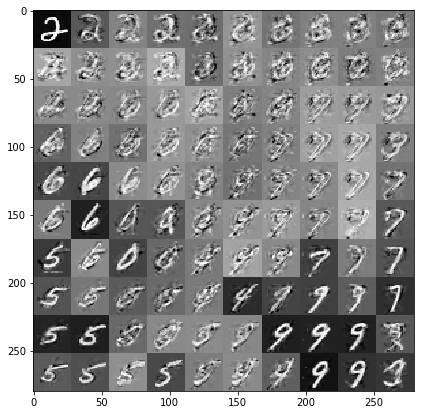

In [35]:
samples = gprm.sample()
samples_ = np.squeeze(samples.numpy())
samples_ = ((samples_ - samples_.min(-1, keepdims=True)) / (samples_.max(-1, keepdims=True) - 
                                                            samples_.min(-1, keepdims=True)))
samples_ = samples_.reshape(sample_grid_points, sample_grid_points, 28, 28)
samples_ = samples_.transpose([0, 2, 1, 3])
samples_ = samples_.reshape(28 * sample_grid_points, 28 * sample_grid_points)
plt.figure(figsize=(7, 7))
ax = plt.subplot()
ax.grid(False)
ax.imshow(-samples_, interpolation='none', cmap='Greys')
plt.show()

# Gaussian Process Regression in Tensorflow Probability

In [52]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()
from mpl_toolkits.mplot3d import Axes3D
%pylab inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_fromat = 'png'

Populating the interactive namespace from numpy and matplotlib


C:\Users\jatin\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test', 'dtype']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
def sinusoid(x):
    return np.sin(3 * np.pi * x[..., 0])

def generate_1d_data(num_training_points, observation_noise_variance):
    index_points_ = np.random.uniform(-1., 1., (num_training_points, 1))
    index_points_ = index_points_.astype(np.float64)
    observations_ = (sinusoid(index_points_) + np.random.normal(loc=0, scale=np.sqrt(observation_noise_variance), 
                                                                size= (num_training_points)))
    return index_points_, observations_

In [5]:
NUM_TRAINING_POINTS = 100
observation_index_points_, observations_ = generate_1d_data(num_training_points=NUM_TRAINING_POINTS, 
                                                            observation_noise_variance=.1)

In [7]:
def build_gp(amplitude, length_scale, observation_noise_variance):
    kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)
    return tfd.GaussianProcess(kernel=kernel, index_points=observation_index_points_, observation_noise_variance=
                              observation_noise_variance)
gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'length_scale': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.)),
    'observations':build_gp
})

In [8]:
x = gp_joint_model.sample()
lp = gp_joint_model.log_prob(x)
print("Samples {}".format(x))
print("log_prob of sample: {}".format(lp))

Samples {'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=0.1606263243751331>, 'length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=0.2357778429270974>, 'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=0.4477225843580788>, 'observations': <tf.Tensor: shape=(100,), dtype=float64, numpy=
array([-6.65609812e-01,  1.16115174e-01,  2.36831705e-01, -4.15086300e-01,
       -9.04428342e-02,  6.67085526e-01, -1.32025308e-01, -5.86043167e-01,
        2.32960390e-01,  3.21214560e-01, -1.32523424e-01,  3.28056585e-01,
        1.79303422e-01,  3.17357888e-01,  7.75034060e-01, -1.34014603e-01,
        7.84429502e-01,  1.93697265e-01, -5.09275911e-01, -1.32578510e-01,
        1.56560107e-01, -9.17965428e-02,  2.95367405e-02, -9.41253483e-01,
       -1.35217761e-01, -4.45132356e-01,  4.29233767e-01,  3.59249205e-01,
       -4.81196957e-02, -1.07709798e+00, -1.68353098e-01, -7.49372623e-01,
        6.13638990e-02,  1.06611471e+00,  7.41064874e-01, -3.82212400e-01,
 

In [9]:
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
amplitude_var = tfp.util.TransformedVariable(initial_value=1., bijector=constrain_positive, name='amplitude', 
                                        dtype=np.float64)
length_scale_var = tfp.util.TransformedVariable(initial_value=1., bijector=constrain_positive, name='length_scale', 
                                               dtype=np.float64)
observation_noise_variance_var = tfp.util.TransformedVariable(initial_value=1., bijector=constrain_positive, name=
                                                             'observation_noise_variance_var', dtype=np.float64)
trainable_variables = [v.trainable_variables[0] for v in [amplitude_var, length_scale_var, 
                                                          observation_noise_variance_var]]

In [12]:
def target_log_prob(amplitude, length_scale, observation_noise_variance):
    return gp_joint_model.log_prob({
        'amplitude': amplitude,
        'length_scale': length_scale,
        'observation_noise_variance': observation_noise_variance,
        'observations':observations_
    })

In [13]:
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=.01)
@tf.function(autograph=False, jit_compile=False)
def train_model():
    with tf.GradientTape() as tape:
        loss = -target_log_prob(amplitude_var, length_scale_var, observation_noise_variance_var)
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss

lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model()
    lls_[i] = loss
    
print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

Trained parameters:
amplitude: 0.9508361454000654
length_scale: 0.184296153721981
observation_noise_variance: 0.10029772174599921


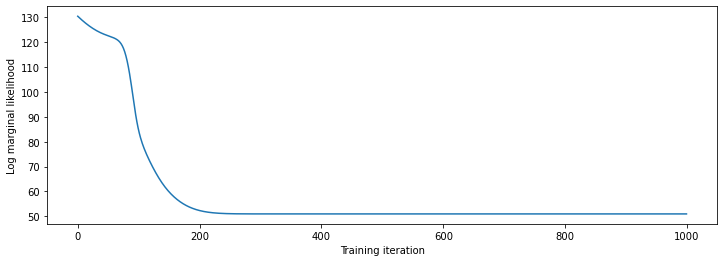

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

In [18]:
predictive_index_points_ = np.linspace(-1.2, 1.2, 200, dtype=np.float64)
predictive_index_points_ = predictive_index_points_[..., np.newaxis]

optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)
gprm = tfd.GaussianProcessRegressionModel(kernel=optimized_kernel, index_points=predictive_index_points_, 
                                        observation_index_points = observation_index_points_, 
                                         observations=observations_, observation_noise_variance=
                                         observation_noise_variance_var, predictive_noise_variance=0.)
num_samples = 50
samples = gprm.sample(num_samples)

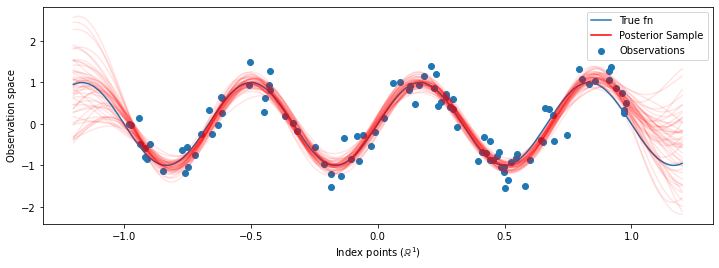

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_), label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_, label='Observations')
for i in range(num_samples):
    plt.plot(predictive_index_points_, samples[i, :], c='r', alpha=.1, label='Posterior Sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

In [23]:
num_results = 100
num_burnin_steps = 50
sampler = tfp.mcmc.TransformedTransitionKernel(tfp.mcmc.NoUTurnSampler(target_log_prob_fn=target_log_prob,
                                                                       step_size=tf.cast(0.1, tf.float64)), 
                                               bijector=[constrain_positive, constrain_positive, constrain_positive])
adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(inner_kernel=sampler, num_adaptation_steps=int(0.8 * 
                                                                                                num_burnin_steps), 
                                                           target_accept_prob=tf.cast(0.75, tf.float64))
initial_state = [tf.cast(x, tf.float64) for x in [1., 1., 1.]]

In [26]:
@tf.function(autograph=False, jit_compile=False)
def do_sampling():
    return tfp.mcmc.sample_chain(kernel=adaptive_sampler, current_state=initial_state, num_results=num_results, 
                                num_burnin_steps=num_burnin_steps, trace_fn=lambda current_state, 
                                 kernel_result: kernel_result)
t0 = time.time()
samples, kernel_results = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s".format(t1-t0))

Inference ran in 12.45s


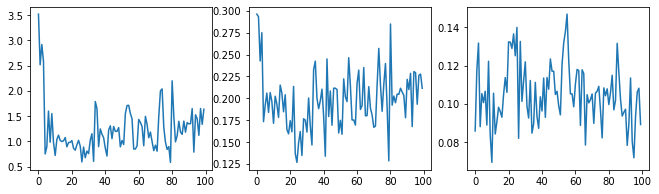

In [27]:
(amplitude_samples, length_scale_samples, observation_noise_variance_samples) = samples
f = plt.figure(figsize=[15, 3])
for i, s in enumerate(samples):
    ax = f.add_subplot(1, len(samples) + 1, i + 1)
    ax.plot(s)

In [30]:
batch_of_posterior_kernels = tfk.ExponentiatedQuadratic(amplitude_samples, length_scale_samples)
batch_gprm = tfd.GaussianProcessRegressionModel(kernel=batch_of_posterior_kernels, index_points=
                                                   predictive_index_points_, observation_index_points=
                                                   observation_index_points_, observations=observations_, 
                                                  observation_noise_variance=observation_noise_variance_samples, 
                                                  predictive_noise_variance=0.)
predictive_gprm = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=tf.zeros([num_results])), 
                                       components_distribution=batch_gprm)
num_samples = 50
samples = predictive_gprm.sample(num_samples)

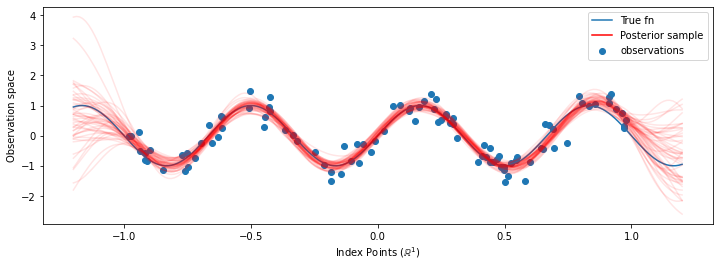

In [31]:
plt.figure(figsize=(12, 4))
plt.plot(predictive_index_points_, sinusoid(predictive_index_points_), label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_, label="observations")
for i in range(num_samples):
    plt.plot(predictive_index_points_, samples[i, :], c="r", alpha=.1, label='Posterior sample' if i == 0 else None)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel(r"Index Points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

# FFJORD 

In [11]:
import numpy as np
import tqdm as tqdm
import sklearn.datasets as skd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import sonnet as snt
tf.enable_v2_behavior()
tfb = tfp.bijectors
tfd = tfp.distributions

In [12]:
def make_grid(xmin, xmax, ymin, ymax, gridlines, pts):
    xpts = np.linspace(xmin, xmax, pts)
    ypts = np.linspace(ymin, ymax, pts)
    xgrid = np.linspace(xmin, xmax, gridlines)
    ygrid = np.linspace(ymin, ymax, gridlines)
    xlines = np.stack([a.ravel() for a in np.meshgrid(xpts, ygrid)])
    ylines = np.stack([a.ravel() for a in np.meshgrid(xgrid, ypts)])
    return np.concatenate([xlines, ylines], 1).T
grid = make_grid(-3, 3, -3, 3, 4, 100)

In [29]:
def plot_density(data, axis):
    x, y = np.squeeze(np.split(data, 2, axis=1))
    levels = np.linspace(0.0, 0.75, 10)
    kwargs = {'levels':levels}
    return sns.kdeplot(x, y, cmap="viridis", shape=True, shade_lowest=True, ax=axis, **kwargs)
def plot_points(data, axis, s=10, color='b', label=''):
    x, y = np.squeeze(np.split(data, 2, axis=1))
    axis.scatter(x, y, c=color, s=s, label=label)
def plot_panel(grid, samples, transformed_grid, transformed_samples, dataset, axarray, limits=True):
    if len(axarray) != 4:
        raise ValueError('Expected 4 axes for the panel')
    ax1, ax2, ax3, ax4 = axarray
    plot_points(data=grid, axis=ax1, s=20, color='black', label='grid')
    plot_points(samples, ax1, s=30, color="blue", label="samples")
    plot_points(transformed_grid, ax2, s=20, color='black', label='ode(grid)')
    plot_points(transformed_samples, ax2, s=30, color='blue', label="ode(samples)")
    ax3 = plot_density(transformed_samples, ax3)
    ax4 = plot_density(dataset, ax4)
    if limits:
        set_limits([ax1], -3.0, 3.0, -3.0, 3.0)
        set_limits([ax2], -2.0, 3.0, -2.0, 3.0)
        set_limits([ax3, ax4], -1.5, 2.5, -0.75, 1.25)
def set_limits(axes, min_x, max_x, min_y, max_y):
    if isinstance(axes, list):
        for axis in axes:
            set_limits(axis, min_x, max_x, min_y, max_y)
    else:
        axes.set_xlim(min_x, max_x)
        axes.set_ylim(min_y, max_y)

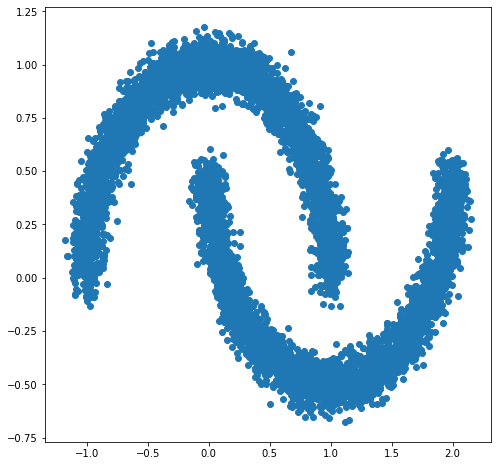

In [17]:
DATASET_SIZE = 1024 * 8
BATCH_SIZE = 256
SAMPLE_SIZE = DATASET_SIZE
moons = skd.make_moons(n_samples=DATASET_SIZE, noise=.06)[0]
moons_ds = tf.data.Dataset.from_tensor_slices(moons.astype(np.float32))
moons_ds = moons_ds.prefetch(tf.data.experimental.AUTOTUNE)
moons_ds = moons_ds.cache()
moons_ds = moons_ds.shuffle(DATASET_SIZE)
moons_ds = moons_ds.batch(BATCH_SIZE)
plt.figure(figsize=[8, 8])
plt.scatter(moons[:, 0], moons[:, 1])
plt.show()

In [19]:
base_loc = np.array([0.0, 0.0]).astype(np.float32)
base_sigma = np.array([0.8, 0.8]).astype(np.float32)
base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)

In [20]:
class MLP_ODE(snt.Module):
    def __init__(self, num_hidden, num_layers, num_output, name='mlp_ode'):
        super(MLP_ODE, self).__init__(name=name)
        self._num_hidden = num_hidden
        self._num_output = num_output
        self._num_layers = num_layers
        self._modules = []
        for _ in range(self._num_layers - 1):
            self._modules.append(snt.Linear(self._num_hidden))
            self._modules.append(tf.math.tanh)
        self._modules.append(snt.Linear(self._num_output))
        self._model = snt.Sequential(self._modules)
    def __call__(self, t, inputs):
        inputs = tf.concat([tf.broadcast_to(t, inputs.shape), inputs], -1)
        return self._model(inputs)

In [21]:
LR = 1e-2
NUM_EPOCHS = 80
STACKED_FFJORDS = 4
NUM_HIDDEN = 8
NUM_LAYERS = 3
NUM_OUTPUT = 2

In [23]:
solver = tfp.math.ode.DormandPrince(atol=1e-5)
ode_solve_fn = solver.solve
trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact
bijectors = []
for _ in range(STACKED_FFJORDS):
    mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT)
    next_ffjord = tfb.FFJORD(state_time_derivative_fn = mlp_model, ode_solve_fn=ode_solve_fn, 
                             trace_augmentation_fn=trace_augmentation_fn)
    bijectors.append(next_ffjord)
stacked_ffjord = tfb.Chain(bijectors[::-1])

In [24]:
transformed_distribution = tfd.TransformedDistribution(distribution=base_distribution, bijector=stacked_ffjord)

In [25]:
@tf.function
def train_step(optimizer, target_sample):
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(transformed_distribution.log_prob(target_sample))
    variables = tape.watched_variables()
    gradients = tape.gradient(loss, variables)
    optimizer.apply(gradients, variables)
    return loss

In [26]:
@tf.function
def get_samples():
    base_distribution_samples = base_distribution.sample(SAMPLE_SIZE)
    transformed_samples = transformed_distribution.sample(SAMPLE_SIZE)
    return base_distribution_samples, transformed_samples

@tf.function
def get_transformed_grid():
    transformed_grid = stacked_ffjord.forward(grid)
    return transformed_grid

In [27]:
evaluation_samples = []
base_samples, transformed_samples = get_samples()
transformed_grid = get_transformed_grid()
evaluation_samples.append((base_samples, transformed_samples, transformed_grid))

C:\Users\jatin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\jatin\anaconda3\lib\site-packages\seaborn\distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\jatin\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'shape'
  cset = contour_func(
C:\Users\jatin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or 

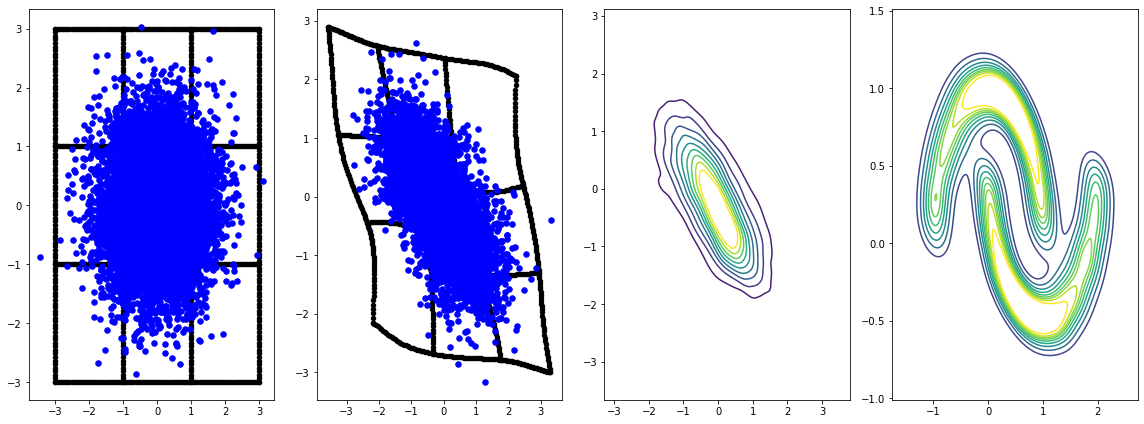

In [30]:
panel_id = 0
panel_data = evaluation_samples[panel_id]
fig, axarray = plt.subplots(1, 4, figsize=(16, 6))
plot_panel(grid, panel_data[0], panel_data[2], panel_data[1], moons, axarray, False)
plt.tight_layout()

In [31]:
learning_rate = tf.Variable(LR, trainable=False)
optimizer = snt.optimizers.Adam(learning_rate)
for epoch in tqdm.trange(NUM_EPOCHS // 2):
    base_samples, transformed_samples = get_samples()
    transformed_grid = get_transformed_grid()
    evaluation_samples.append((base_samples, transformed_samples, transformed_grid))
    for batch in moons_ds:
        _ = train_step(optimizer, batch)

  0%|          | 0/40 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


100%|██████████| 40/40 [07:13<00:00, 10.85s/it]  


C:\Users\jatin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\jatin\anaconda3\lib\site-packages\seaborn\distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\jatin\anaconda3\lib\site-packages\seaborn\distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'shape'
  cset = contour_func(
C:\Users\jatin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or 

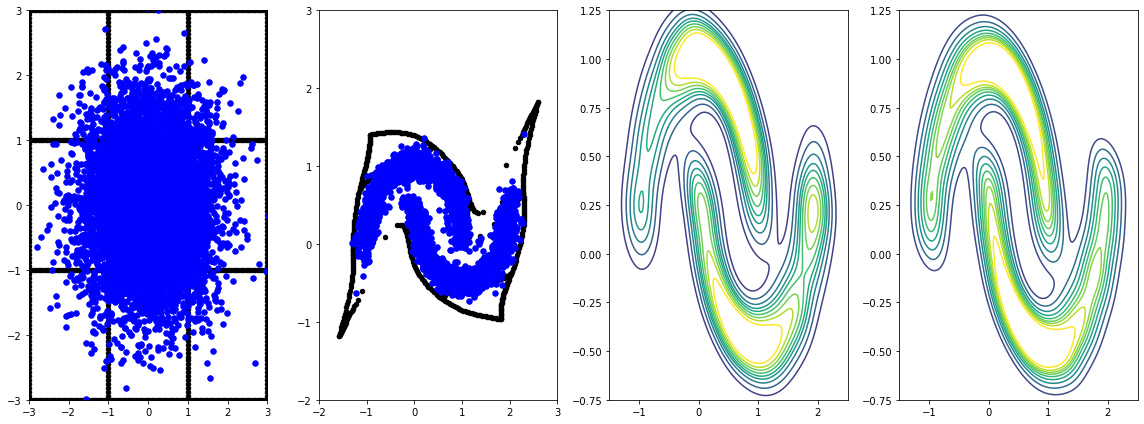

In [32]:
panel_id = -1
panel_data = evaluation_samples[panel_id]
fig, axarray = plt.subplots(1, 4, figsize=(16, 6))
plot_panel(grid, panel_data[0], panel_data[2], panel_data[1], moons, axarray)
plt.tight_layout()

# Linear Mixed Effects Models

In [36]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
dtype = tf.float64
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('ggplot')

In [37]:
def load_insteval():
    url = 'https://raw.github.com/vincentarelbundock/Rdatasets/master/csv/lme4/InstEval.csv'
    with requests.Session() as s:
        download = s.get(url)
        f = download.content.decode().splitlines()
    iterator = csv.reader(f)
    columns = next(iterator)[1:]
    x_train = np.array([row[1:] for row in iterator], dtype=np.int)
    metadata = {'columns': columns}
    return x_train, metadata

In [38]:
data, metadata = load_insteval()
data

array([[   1, 1002,    2, ...,    0,    2,    5],
       [   1, 1050,    2, ...,    1,    6,    2],
       [   1, 1582,    2, ...,    0,    2,    5],
       ...,
       [2972, 2084,    4, ...,    0,   10,    5],
       [2972, 2110,    4, ...,    1,    4,    1],
       [2972, 2121,    4, ...,    1,    2,    3]])

In [39]:
metadata

{'columns': ['s', 'd', 'studage', 'lectage', 'service', 'dept', 'y']}

In [40]:
data = pd.DataFrame(data, columns=metadata['columns'])
data = data.rename(columns={'s':'student', 'd':'instructors', 'dept':'departments', 'y':'ratings'})
data['sudents'] = data["instructors"]
data["departments"] = data["departments"]
train = data.sample(frac=0.8)
test = data.drop(train.index)
train.head()

,student,instructors,studage,lectage,service,departments,ratings,sudents
51463,2067,1717,8,4,0,15,4,1717
59112,2394,1817,2,2,1,11,1,1817
68294,2781,1864,8,4,0,7,5,1864
29273,1190,1056,4,2,1,8,4,1056
1262,56,676,6,6,0,4,5,676


In [41]:
test

,student,instructors,studage,lectage,service,departments,ratings,sudents
0,1,1002,2,2,0,2,5,1002
9,3,140,2,1,0,10,4,140
12,3,494,2,1,1,9,4,494
13,3,625,2,2,0,10,3,625
30,5,1439,2,1,0,5,5,1439
...,...,...,...,...,...,...,...,...
73394,2972,140,4,2,0,10,3,140
73409,2972,1056,4,2,1,8,5,1056
73410,2972,1106,4,1,1,4,3,1106
73411,2972,1203,4,3,1,3,5,1203


In [42]:
get_value = lambda dataframe, key, dtype: dataframe[key].values.astype(dtype)
features_train = {k: get_value(train, key=k, dtype=np.int32) for k in ['student', 'instructors', 'departments', 
                                                                       'service']}
labels_train = get_value(train, key="ratings", dtype=np.int32)
features_test = {k: get_value(test, key=k, dtype=np.int32) for k in ['student', 'instructors', 'departments', 
                                                                     'service']}
labels_test = get_value(test, key = 'ratings', dtype=np.float32)

In [43]:
num_students = max(features_train['student']) + 1
num_instructors = max(features_train['instructors']) + 1
num_departments = max(features_train['departments']) + 1
num_observations = train.shape[0]
print("Number of students:", num_students)
print("Number of instructors:", num_instructors)
print("Number of departments:", num_departments)
print("Number of observations:", num_observations)

Number of students: 2973
Number of instructors: 2161
Number of departments: 16
Number of observations: 58737


In [44]:
class LinearMixedEffectModel(tf.Module):
    def __init__(self):
        self._intercept = tf.Variable(0., name="intercept")
        self._effect_service = tf.Variable(0., name="effect_service")
        self._stddev_students = tfp.util.TransformedVariable(1., bijector=tfb.Exp(), name="stddev_students")
        self._stddev_instructors = tfp.util.TransformedVariable(1., bijector=tfb.Exp(), name="stddev_instructors")
        self._stddev_departments = tfp.util.TransformedVariable(1., bijector=tfb.Exp(), name="steddev_departments")
    def __call__(self, features):
        model = tfd.JointDistributionSequential([
            tfd.MultivariateNormalDiag(loc=tf.zeros(num_students), scale_identity_multiplier=self._stddev_students),
            tfd.MultivariateNormalDiag(loc=tf.zeros(num_instructors),
                                       scale_identity_multiplier=self._stddev_instructors),
            tfd.MultivariateNormalDiag(loc=tf.zeros(num_departments), 
                                       scale_identity_multiplier=self._stddev_departments),
            lambda effect_departments, effect_instructors, effect_students: tfd.Independent(tfd.Normal(
            loc=(self._effect_service * features['service'] + 
                tf.gather(effect_students, features["student"], axis=-1) + 
                tf.gather(effect_instructors, features["instructors"], axis=-1) + 
                tf.gather(effect_departments, features["departments"], axis=-1) + 
                self._intercept), scale=-1), reinterpreted_batch_ndims=1)
        ])
        model._to_track = self
        return model
lmm_jointdist = LinearMixedEffectModel()
lmm_train = lmm_jointdist(features_train)

In [45]:
lmm_train.trainable_variables

(<tf.Variable 'stddev_students:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'stddev_instructors:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'steddev_departments:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'effect_service:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'intercept:0' shape=() dtype=float32, numpy=0.0>)

In [46]:
lmm_train.resolve_graph()

(('effect_students', ()),
 ('effect_instructors', ()),
 ('effect_departments', ()),
 ('x', ('effect_departments', 'effect_instructors', 'effect_students')))

In [47]:
target_log_prob_fn = lambda *x: lmm_train.log_prob(x + (labels_train,))
trainable_variables = lmm_train.trainable_variables
current_state = lmm_train.sample()[:-1]

In [48]:
target_log_prob_fn(*current_state)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [49]:
hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=target_log_prob_fn, step_size=0.015, num_leapfrog_steps=3)
kernel_results = hmc.bootstrap_results(current_state)

@tf.function(autograph=False, jit_compile=True)
def one_e_step(current_state, kernel_results):
    next_state, next_kernel_results = hmc.one_step(current_state=current_state, previous_kernel_results=kernel_results)
    return next_state, next_kernel_results

optimizer = tf.optimizers.Adam(learning_rate=.01)

@tf.function(autograph=False, jit_compile=True)
def one_m_step(current_state):
    with tf.GradientTape() as tape:
        loss = -target_log_prob_fn(*current_state)
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss

In [50]:
num_warmup_iters = 1000
num_iters = 1500
num_accepted = 0
effect_students_samples = np.zeros([num_iters, num_students])
effect_instructors_samples = np.zeros([num_iters, num_instructors])
effect_departments_samples = np.zeros([num_iters, num_departments])
loss_history = np.zeros([num_iters])

In [51]:
for t in range(num_warmup_iters):
    current_state, kernel_results = one_e_step(current_state, kernel_results)
    num_accepted += kernel_results.is_accepted.numpy()
    if t % 500 == 0 or t == num_warmup_iters - 1:
        print("Warm-Up Iteration: {:>3} Acceptance Rate: {:.3f}".format(t, num_accepted / (t + 1)))
num_accepted = 0
for t in range(num_iters):
    for _ in range(5):
        current_state, kernel_results = one_e_step(current_state, kernel_results)
    loss = one_m_step(current_state)
    effect_students_samples[t, :] = current_state[0].numpy()
    effect_instructors_samples[t, :] = current_state[1].numpy()
    effect_departments_samples[t, :] = current_state[2].numpy()
    num_accepted += kernel_results.is_accepted.numpy()
    loss_history[t] = loss.numpy()
    if t % 500 == 0 or t == num_iters - 1:
        print("Iteration: {:>4} Acceptance Rate: {:.3f} Loss: {:.3f}".format(t, num_accepted / (t + 1), 
                                                                             loss_history[t]))

Warm-Up Iteration:   0 Acceptance Rate: 0.000
Warm-Up Iteration: 500 Acceptance Rate: 0.000
Warm-Up Iteration: 999 Acceptance Rate: 0.000
Iteration:    0 Acceptance Rate: 0.000 Loss: nan
Iteration:  500 Acceptance Rate: 0.000 Loss: nan
Iteration: 1000 Acceptance Rate: 0.000 Loss: nan
Iteration: 1499 Acceptance Rate: 0.000 Loss: nan


# Probabilistic PCA